In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.utils import make_grid
# import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import math
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [2]:
df = pd.read_csv("train.csv")

In [3]:
len(df)

42000

In [4]:
df['label'].value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [5]:
# Find the maximum number of occurrences of any digit
max_size = df['label'].value_counts().max()

# Use pd.concat to create a list of dataframes to be concatenated
frames = [df]  # Start with the original dataframe

# Loop through each class group and append necessary duplicates
for class_index, group in df.groupby('label'):
    samples_to_add = max_size - len(group)
    if samples_to_add > 0:
        frames.append(group.sample(samples_to_add, replace=True))

# Concatenate all the frames together and shuffle the dataframe
df = pd.concat(frames).sample(frac=1).reset_index(drop=True)

# Check the new value counts to confirm balancing
print(df['label'].value_counts())

label
7    4684
5    4684
6    4684
2    4684
3    4684
9    4684
0    4684
1    4684
8    4684
4    4684
Name: count, dtype: int64


In [6]:
# 1 represents real, 0 fake
df['label'] = 1

In [7]:
X_discriminator = df.drop('label', axis=1)
y_discriminator = torch.tensor(df['label'].values, dtype=torch.float32)

In [8]:
pixel_columns = df.shape[1] - 1  # subtracting 1 for the label column

image_side_length = int(pixel_columns**0.5)
print(f"Each image is {image_side_length}x{image_side_length} pixels.")

Each image is 28x28 pixels.


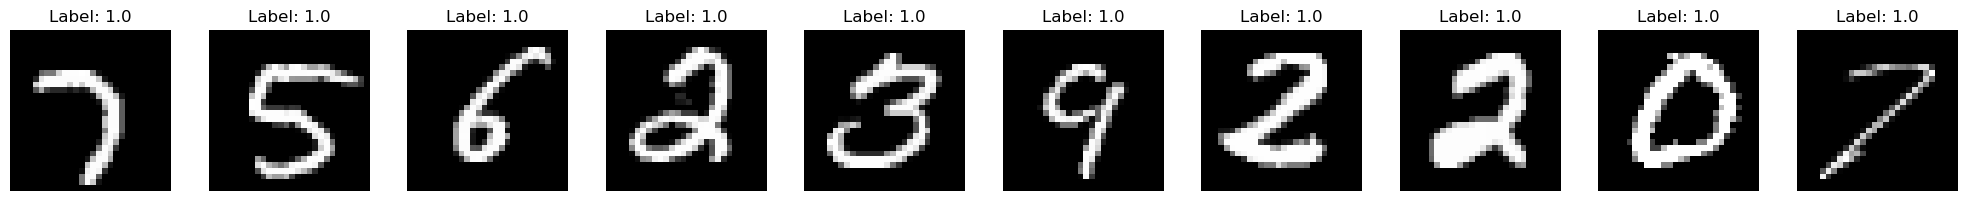

In [9]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  
for i, ax in enumerate(axes):
    # Reshape each row into 28x28 array and plot
    img = X_discriminator.iloc[i].to_numpy().reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_discriminator[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
X_discriminator = X_discriminator.values.reshape(-1, 1, 28, 28)
X_discriminator = (torch.tensor(X_discriminator).float() / 255.0) * 2 - 1

In [11]:
dataset_discriminator = TensorDataset(X_discriminator, y_discriminator)
loader_discriminator = DataLoader(dataset_discriminator, batch_size=64, shuffle=True)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features=128*7*7, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))

        x = F.relu(self.conv6(x))
        x = x.view(-1, 128*7*7)
        x = self.dropout(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [13]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(in_features=noise_dim, out_features=noise_dim) # (1, 49) -> (1, 7, 7)
        self.convT1 = nn.ConvTranspose2d(in_channels=1, out_channels=128, kernel_size=4, stride=1)  # (1, 7, 7) -> (1, 10, 10)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.convT2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2) # (1, 10, 10) -> (1, 22, 22)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.convT3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1) # (1, 22, 22) -> (1, 24, 24)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.convT4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1) # (1, 24, 24) -> (1, 26, 26)
        self.bn4 = nn.BatchNorm2d(num_features=16)
        # self.dropout = nn.Dropout(0.3)
        self.convT5 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1) # (1, 26, 26) -> (1, 28, 28)

    def forward(self, x):
        x = F.leaky_relu(self.fc(x))
        x = x.view(-1, 1, int(math.sqrt(noise_dim)), int(math.sqrt(noise_dim)))
        x = F.relu(self.bn1(self.convT1(x)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))
        # x = self.dropout(x)
        x = torch.tanh(self.convT5(x))
        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 49
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)

optim_G = torch.optim.Adam(generator.parameters(), lr=0.0001024, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001024, betas=(0.5, 0.999))
scheduler_G = StepLR(optimizer=optim_G, step_size=20, gamma=0.8)
scheduler_D = StepLR(optimizer=optim_D, step_size=20, gamma=0.8)

100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.09it/s, loss_D=1.37, loss_G=0.64]


Epoch [1/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [1/400] - Average D loss: 1.2883, Average G loss: 0.7911


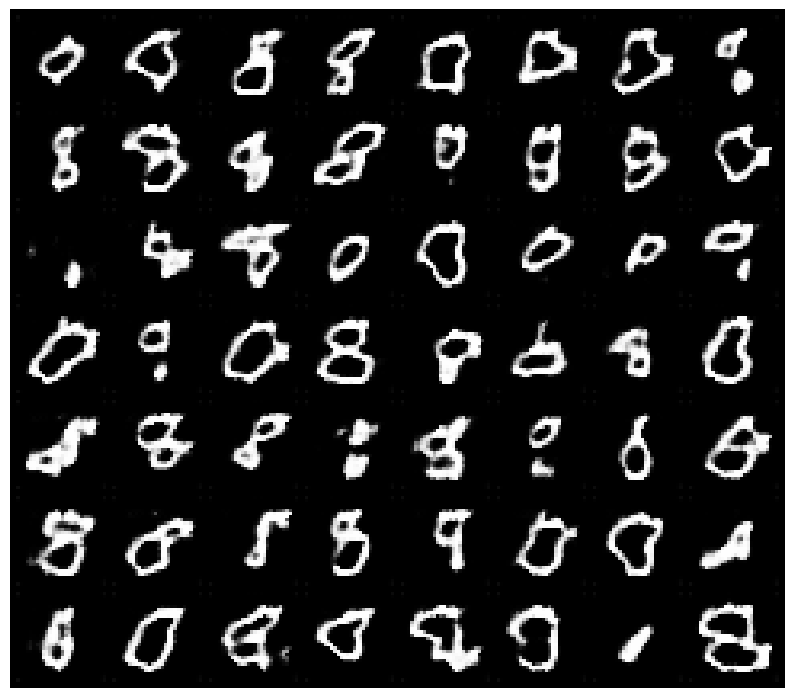

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.99it/s, loss_D=1.2, loss_G=0.933]


Epoch [2/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [2/400] - Average D loss: 1.2269, Average G loss: 0.8820


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.33it/s, loss_D=1.21, loss_G=0.696]


Epoch [3/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [3/400] - Average D loss: 1.1645, Average G loss: 0.9773


100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.25it/s, loss_D=1.23, loss_G=1.48]


Epoch [4/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [4/400] - Average D loss: 1.1147, Average G loss: 1.0372


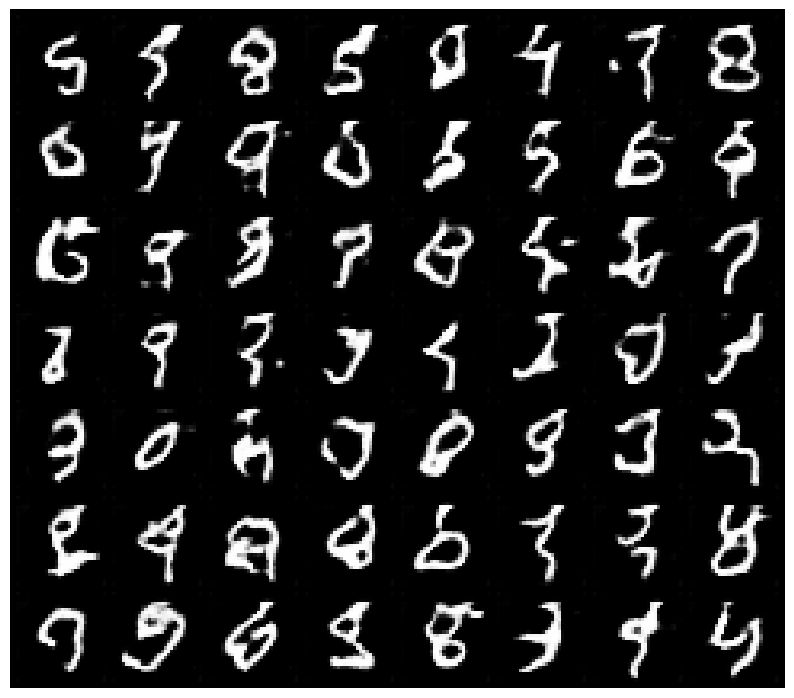

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.83it/s, loss_D=1.12, loss_G=1.17]


Epoch [5/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [5/400] - Average D loss: 1.0689, Average G loss: 1.0997


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.98it/s, loss_D=0.953, loss_G=1.28]


Epoch [6/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [6/400] - Average D loss: 1.0307, Average G loss: 1.1664


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.82it/s, loss_D=0.939, loss_G=1.28]


Epoch [7/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [7/400] - Average D loss: 1.0133, Average G loss: 1.2021


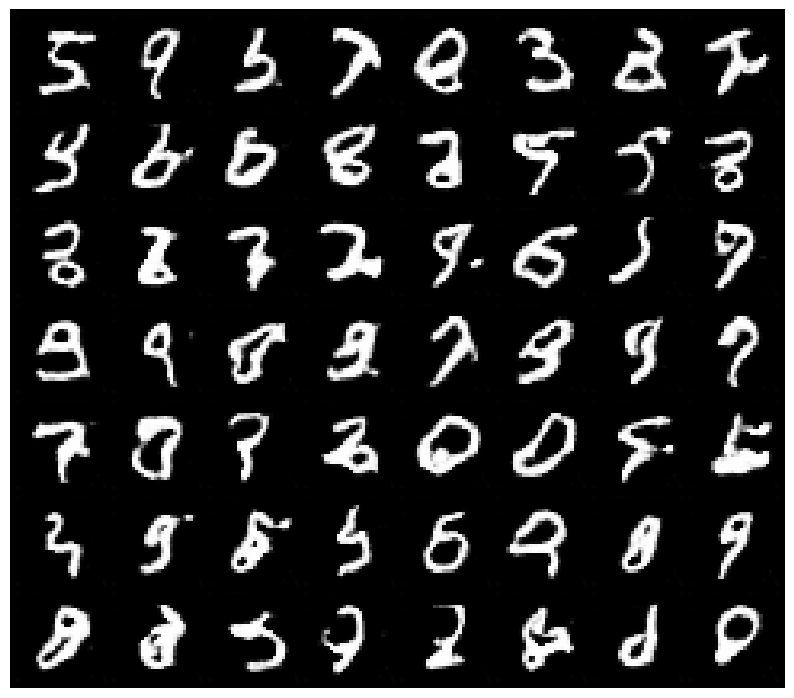

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.96it/s, loss_D=1.05, loss_G=1.25]


Epoch [8/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [8/400] - Average D loss: 0.9769, Average G loss: 1.2657


100%|███████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.91it/s, loss_D=1.1, loss_G=1.95]


Epoch [9/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [9/400] - Average D loss: 0.9501, Average G loss: 1.3200


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.66it/s, loss_D=0.738, loss_G=1.46]


Epoch [10/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [10/400] - Average D loss: 0.9094, Average G loss: 1.3833


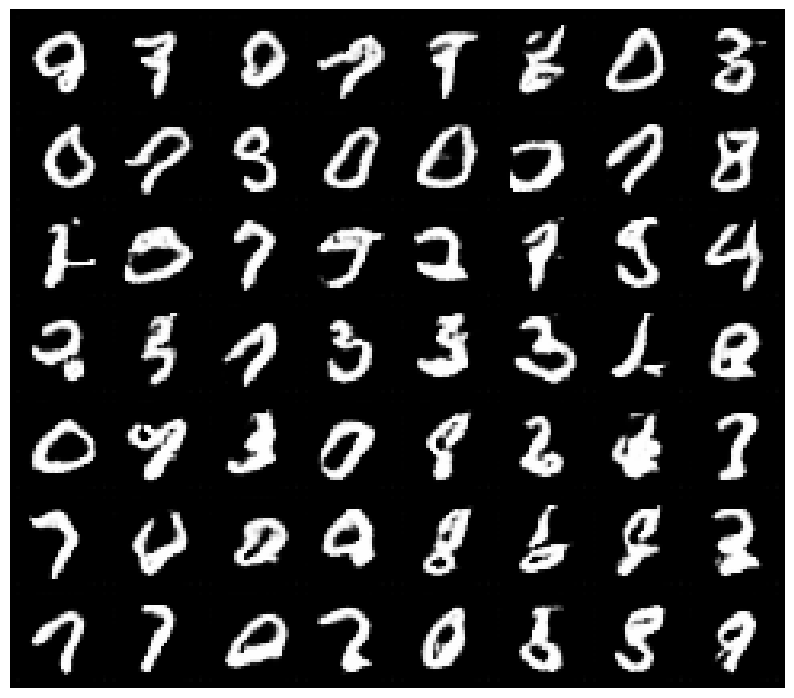

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.02it/s, loss_D=0.84, loss_G=1.72]


Epoch [11/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [11/400] - Average D loss: 0.8691, Average G loss: 1.4648


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.07it/s, loss_D=0.858, loss_G=1.11]


Epoch [12/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [12/400] - Average D loss: 0.8422, Average G loss: 1.5330


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.02it/s, loss_D=0.857, loss_G=1.96]


Epoch [13/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [13/400] - Average D loss: 0.8124, Average G loss: 1.5971


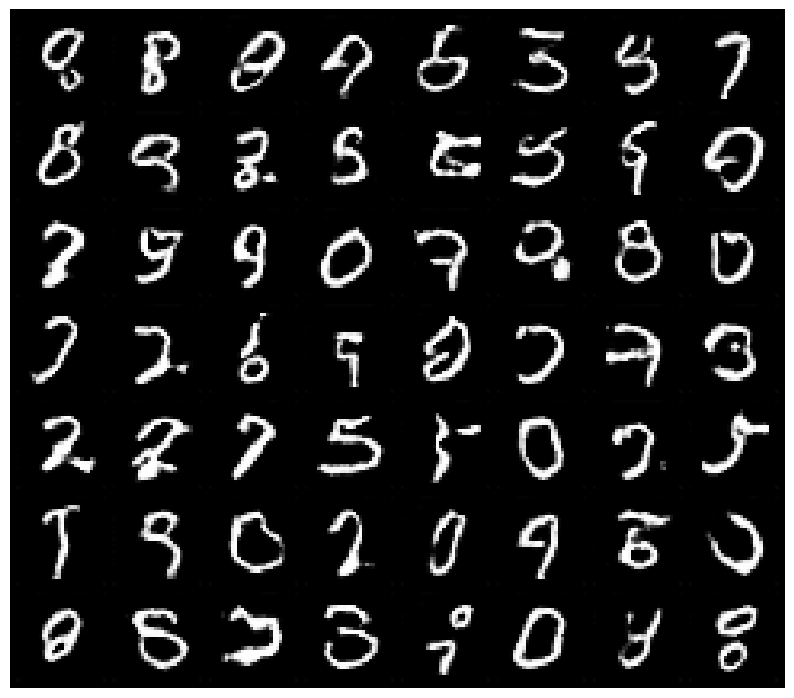

100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.09it/s, loss_D=1.08, loss_G=2.46]


Epoch [14/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [14/400] - Average D loss: 0.7921, Average G loss: 1.6507


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.09it/s, loss_D=0.744, loss_G=1.65]


Epoch [15/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [15/400] - Average D loss: 0.7712, Average G loss: 1.6870


100%|██████████████████████████████████████████████████████| 732/732 [00:50<00:00, 14.35it/s, loss_D=0.71, loss_G=1.73]


Epoch [16/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [16/400] - Average D loss: 0.7569, Average G loss: 1.7334


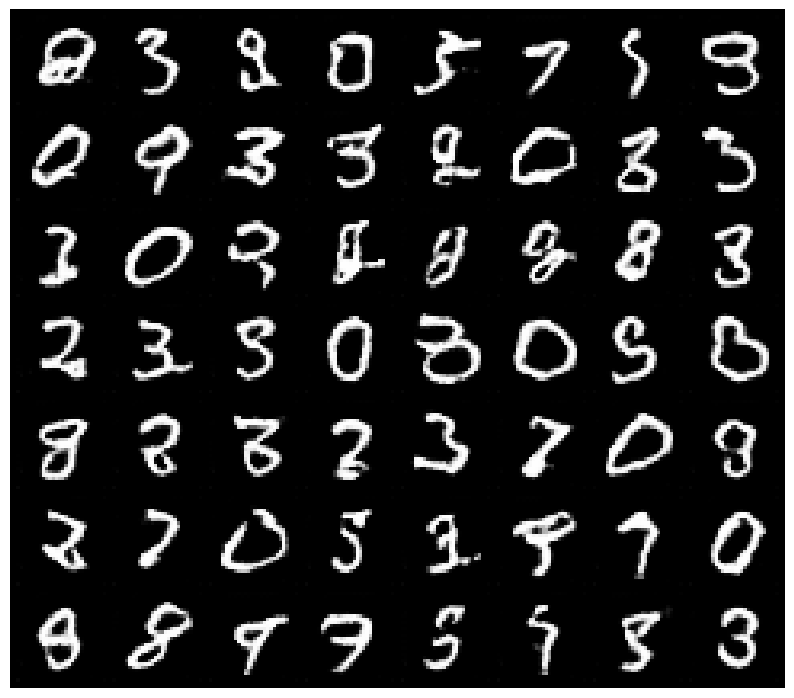

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.17it/s, loss_D=0.921, loss_G=1.09]


Epoch [17/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [17/400] - Average D loss: 0.7632, Average G loss: 1.7197


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.16it/s, loss_D=0.887, loss_G=2.38]


Epoch [18/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [18/400] - Average D loss: 0.7630, Average G loss: 1.7241


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.22it/s, loss_D=0.577, loss_G=2.07]


Epoch [19/400] - LR G: 0.0001024, LR D: 0.0001024
Epoch [19/400] - Average D loss: 0.7457, Average G loss: 1.7652


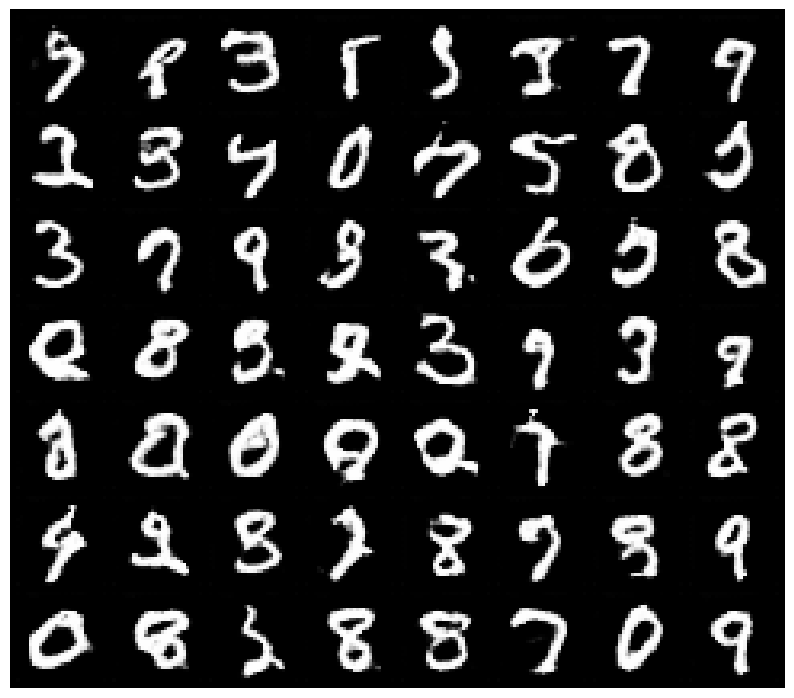

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.89it/s, loss_D=0.57, loss_G=1.98]


Epoch [20/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [20/400] - Average D loss: 0.7351, Average G loss: 1.7922


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.03it/s, loss_D=0.767, loss_G=1.7]


Epoch [21/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [21/400] - Average D loss: 0.7199, Average G loss: 1.8354


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.20it/s, loss_D=0.753, loss_G=1.65]


Epoch [22/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [22/400] - Average D loss: 0.7090, Average G loss: 1.8510


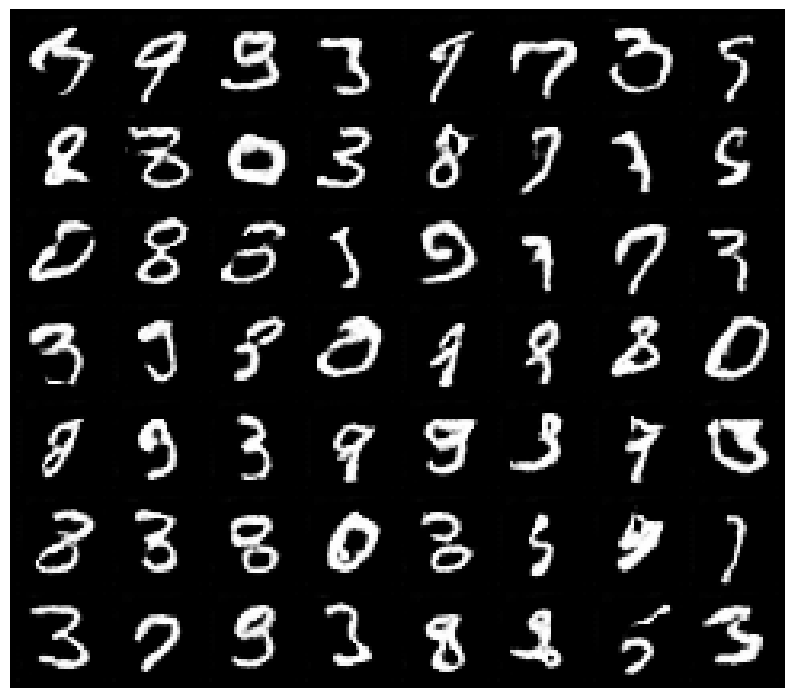

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.95it/s, loss_D=0.737, loss_G=1.99]


Epoch [23/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [23/400] - Average D loss: 0.7092, Average G loss: 1.8361


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.95it/s, loss_D=0.512, loss_G=2.26]


Epoch [24/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [24/400] - Average D loss: 0.7131, Average G loss: 1.8308


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.07it/s, loss_D=0.615, loss_G=1.88]


Epoch [25/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [25/400] - Average D loss: 0.7032, Average G loss: 1.8590


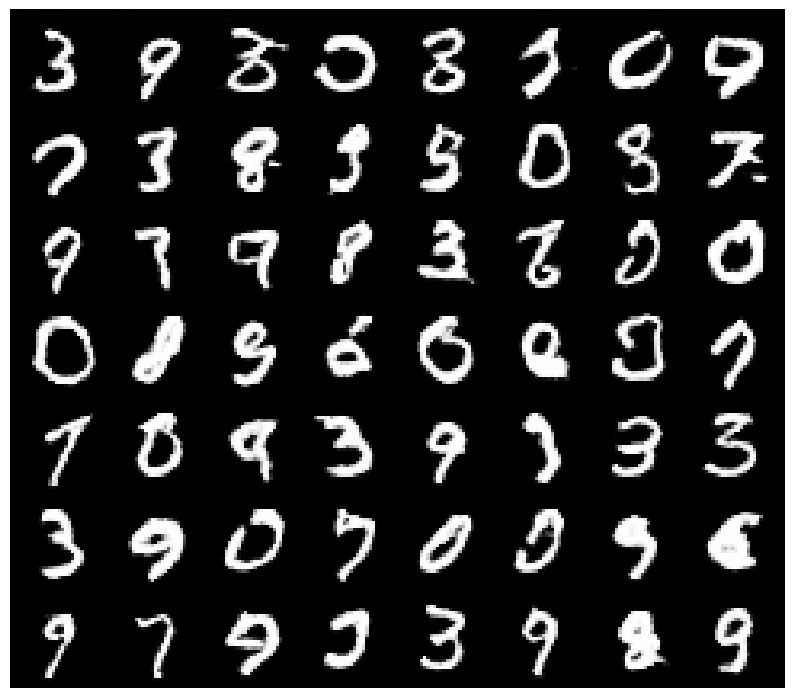

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.04it/s, loss_D=0.743, loss_G=1.6]


Epoch [26/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [26/400] - Average D loss: 0.7054, Average G loss: 1.8641


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.92it/s, loss_D=0.733, loss_G=2.07]


Epoch [27/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [27/400] - Average D loss: 0.6956, Average G loss: 1.8798


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.74it/s, loss_D=0.607, loss_G=1.55]


Epoch [28/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [28/400] - Average D loss: 0.6909, Average G loss: 1.8926


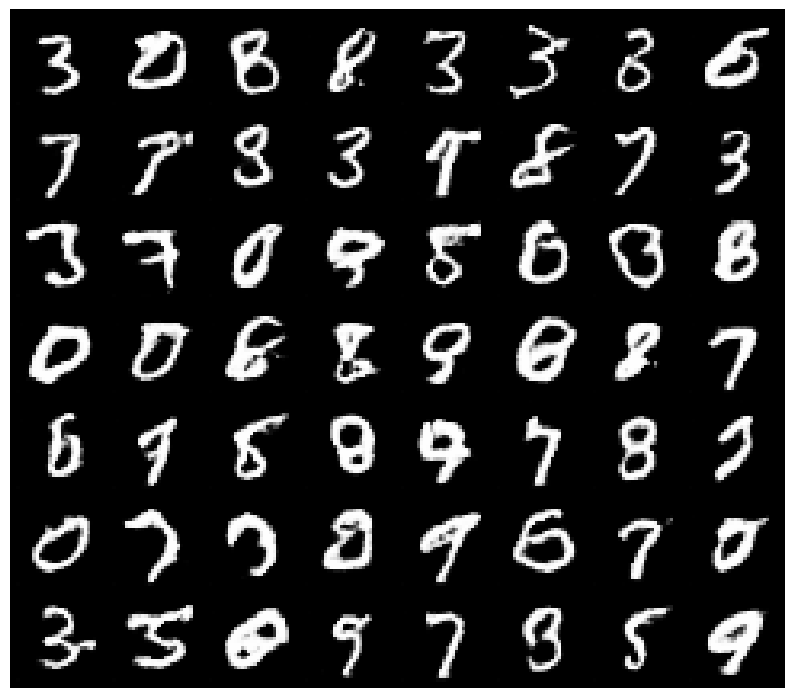

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.651, loss_G=1.53]


Epoch [29/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [29/400] - Average D loss: 0.6854, Average G loss: 1.8961


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.618, loss_G=2.24]


Epoch [30/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [30/400] - Average D loss: 0.6863, Average G loss: 1.9010


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.78it/s, loss_D=0.677, loss_G=1.77]


Epoch [31/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [31/400] - Average D loss: 0.6784, Average G loss: 1.9202


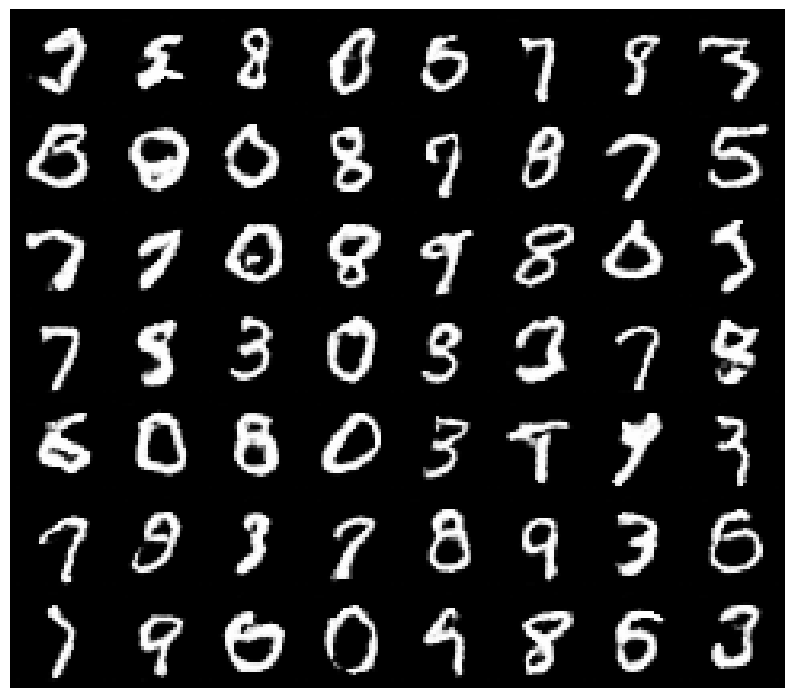

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.98it/s, loss_D=0.742, loss_G=1.99]


Epoch [32/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [32/400] - Average D loss: 0.6735, Average G loss: 1.9270


100%|███████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.7, loss_G=1.51]


Epoch [33/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [33/400] - Average D loss: 0.6746, Average G loss: 1.9310


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.75it/s, loss_D=0.778, loss_G=1.65]


Epoch [34/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [34/400] - Average D loss: 0.6643, Average G loss: 1.9562


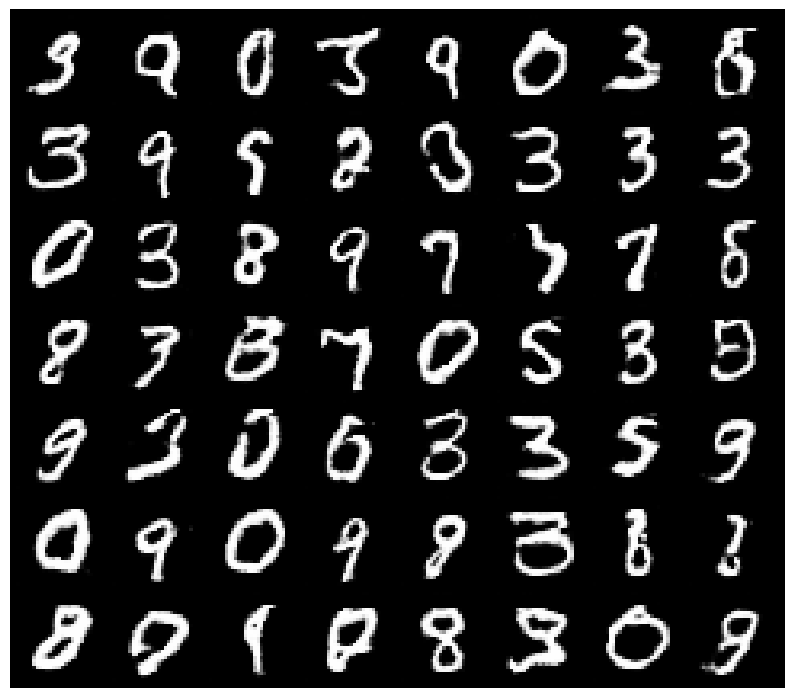

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.80it/s, loss_D=0.704, loss_G=2.29]


Epoch [35/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [35/400] - Average D loss: 0.6619, Average G loss: 1.9722


100%|███████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.66, loss_G=1.9]


Epoch [36/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [36/400] - Average D loss: 0.6574, Average G loss: 1.9756


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.68it/s, loss_D=0.745, loss_G=1.56]


Epoch [37/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [37/400] - Average D loss: 0.6611, Average G loss: 1.9808


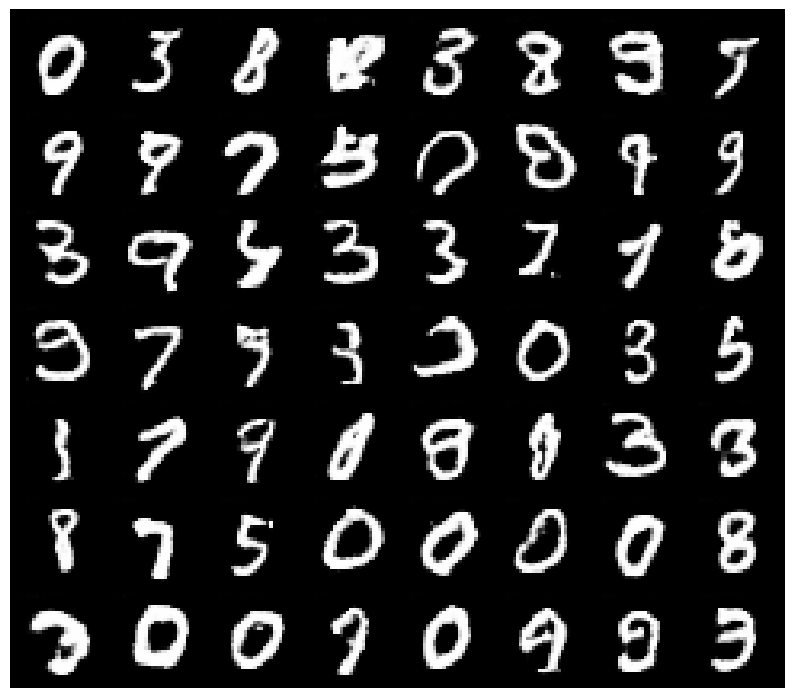

100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.75it/s, loss_D=0.73, loss_G=1.93]


Epoch [38/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [38/400] - Average D loss: 0.6574, Average G loss: 1.9959


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.81it/s, loss_D=0.694, loss_G=1.86]


Epoch [39/400] - LR G: 0.0000819, LR D: 0.0000819
Epoch [39/400] - Average D loss: 0.6548, Average G loss: 2.0030


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.788, loss_G=1.78]


Epoch [40/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [40/400] - Average D loss: 0.6491, Average G loss: 2.0075


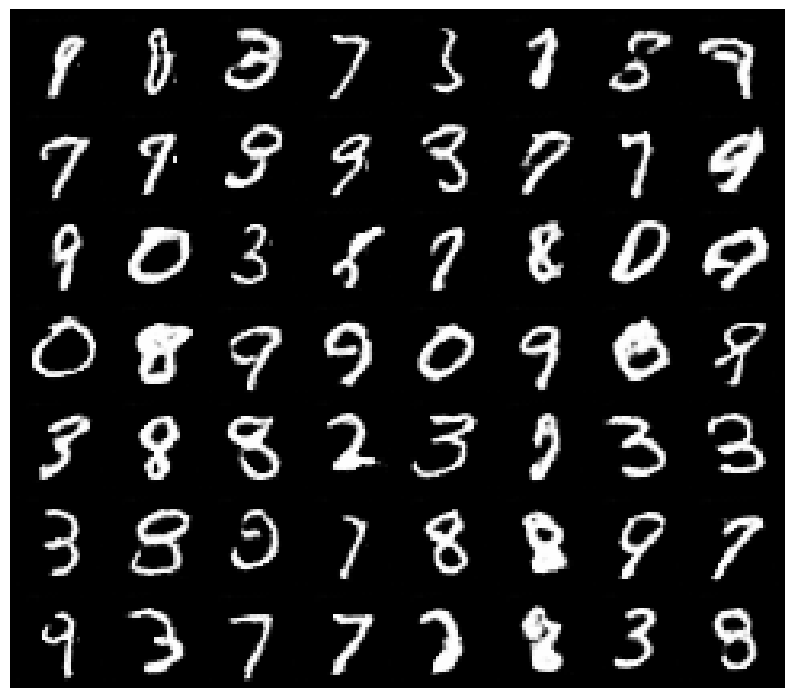

100%|███████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.93it/s, loss_D=0.8, loss_G=1.32]


Epoch [41/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [41/400] - Average D loss: 0.6485, Average G loss: 1.9964


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.21it/s, loss_D=0.605, loss_G=2.21]


Epoch [42/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [42/400] - Average D loss: 0.6445, Average G loss: 1.9971


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.03it/s, loss_D=0.611, loss_G=2.14]


Epoch [43/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [43/400] - Average D loss: 0.6447, Average G loss: 2.0011


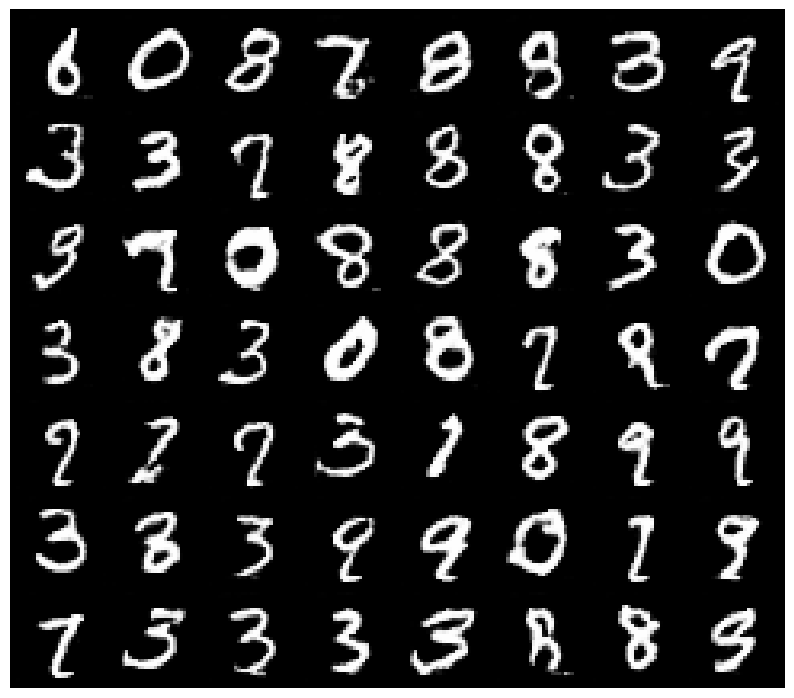

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.02it/s, loss_D=0.524, loss_G=1.79]


Epoch [44/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [44/400] - Average D loss: 0.6483, Average G loss: 2.0057


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.609, loss_G=2.09]


Epoch [45/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [45/400] - Average D loss: 0.6417, Average G loss: 2.0174


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.656, loss_G=1.66]


Epoch [46/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [46/400] - Average D loss: 0.6411, Average G loss: 2.0206


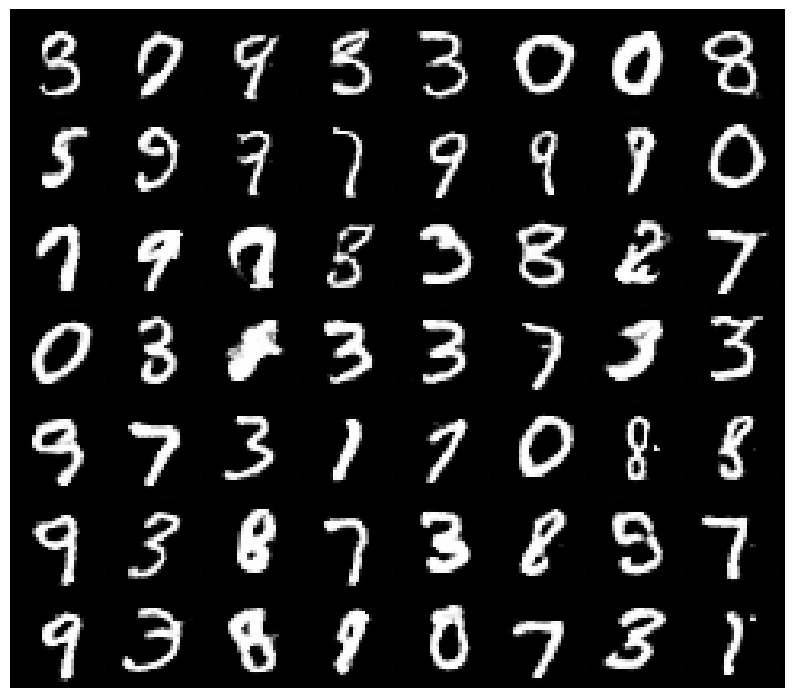

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.71it/s, loss_D=0.702, loss_G=1.47]


Epoch [47/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [47/400] - Average D loss: 0.6398, Average G loss: 2.0231


100%|███████████████████████████████████████████████████████| 732/732 [01:08<00:00, 10.66it/s, loss_D=0.8, loss_G=1.41]


Epoch [48/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [48/400] - Average D loss: 0.6390, Average G loss: 2.0234


100%|█████████████████████████████████████████████████████| 732/732 [01:11<00:00, 10.18it/s, loss_D=0.683, loss_G=1.83]


Epoch [49/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [49/400] - Average D loss: 0.6390, Average G loss: 2.0206


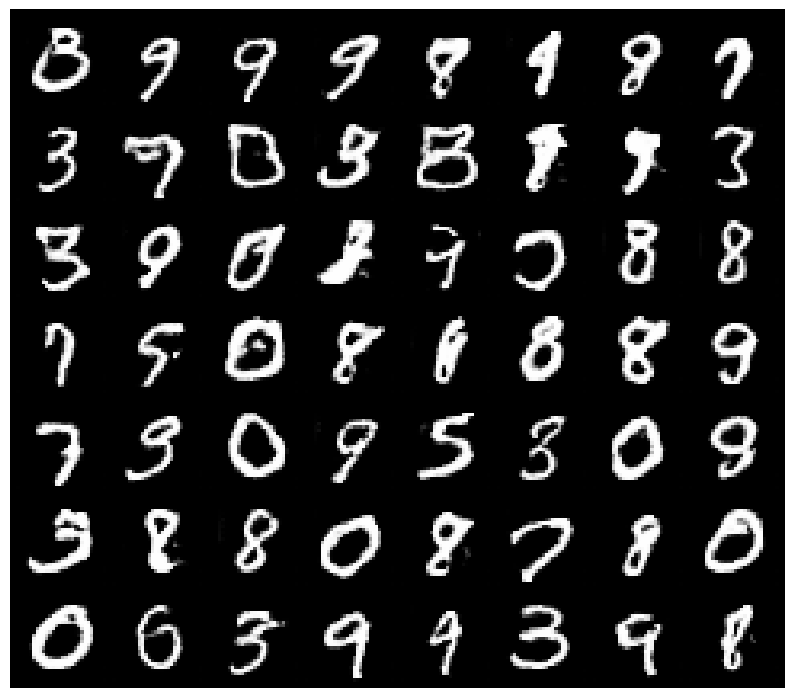

100%|█████████████████████████████████████████████████████| 732/732 [01:11<00:00, 10.23it/s, loss_D=0.644, loss_G=1.75]


Epoch [50/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [50/400] - Average D loss: 0.6327, Average G loss: 2.0338


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=0.729, loss_G=1.71]


Epoch [51/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [51/400] - Average D loss: 0.6370, Average G loss: 2.0311


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.679, loss_G=2.54]


Epoch [52/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [52/400] - Average D loss: 0.6335, Average G loss: 2.0280


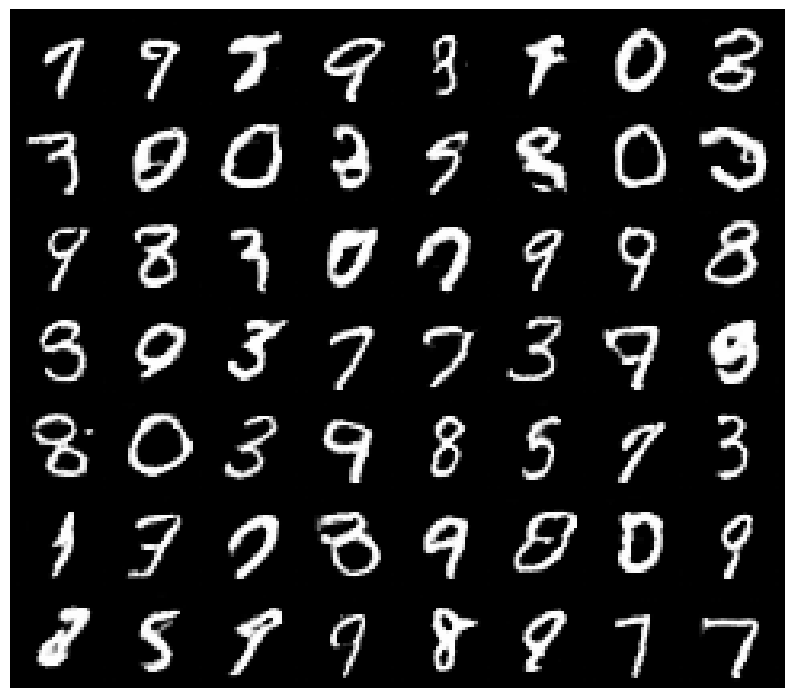

100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.70it/s, loss_D=0.55, loss_G=1.94]


Epoch [53/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [53/400] - Average D loss: 0.6320, Average G loss: 2.0360


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.423, loss_G=2.24]


Epoch [54/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [54/400] - Average D loss: 0.6284, Average G loss: 2.0610


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.74it/s, loss_D=0.678, loss_G=1.89]


Epoch [55/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [55/400] - Average D loss: 0.6250, Average G loss: 2.0502


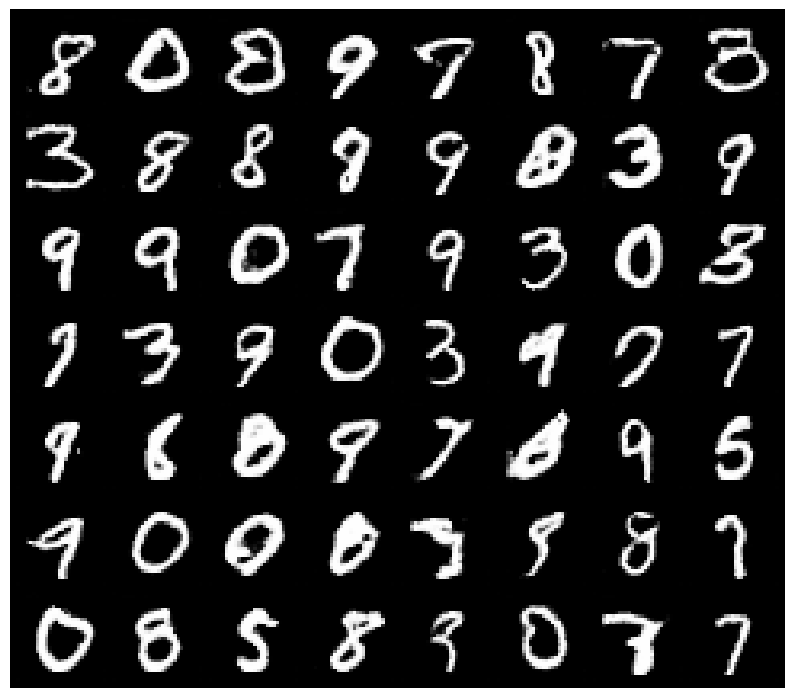

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.74it/s, loss_D=0.591, loss_G=1.71]


Epoch [56/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [56/400] - Average D loss: 0.6230, Average G loss: 2.0657


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.75it/s, loss_D=0.467, loss_G=2.36]


Epoch [57/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [57/400] - Average D loss: 0.6257, Average G loss: 2.0636


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.83it/s, loss_D=0.707, loss_G=1.91]


Epoch [58/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [58/400] - Average D loss: 0.6244, Average G loss: 2.0614


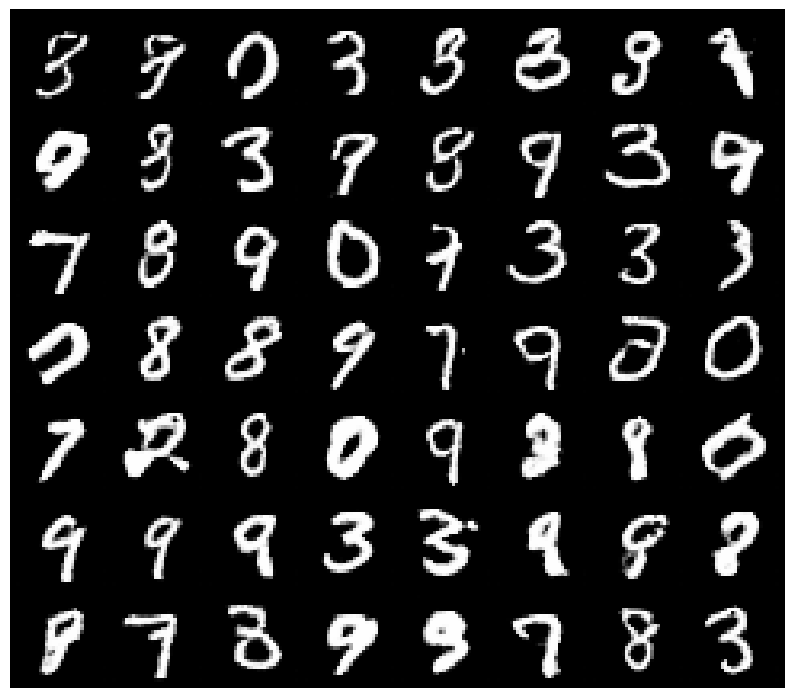

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.71it/s, loss_D=0.564, loss_G=2.36]


Epoch [59/400] - LR G: 0.0000655, LR D: 0.0000655
Epoch [59/400] - Average D loss: 0.6235, Average G loss: 2.0644


100%|███████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.59it/s, loss_D=0.7, loss_G=2.04]


Epoch [60/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [60/400] - Average D loss: 0.6199, Average G loss: 2.0627


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.67it/s, loss_D=0.649, loss_G=1.87]


Epoch [61/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [61/400] - Average D loss: 0.6205, Average G loss: 2.0563


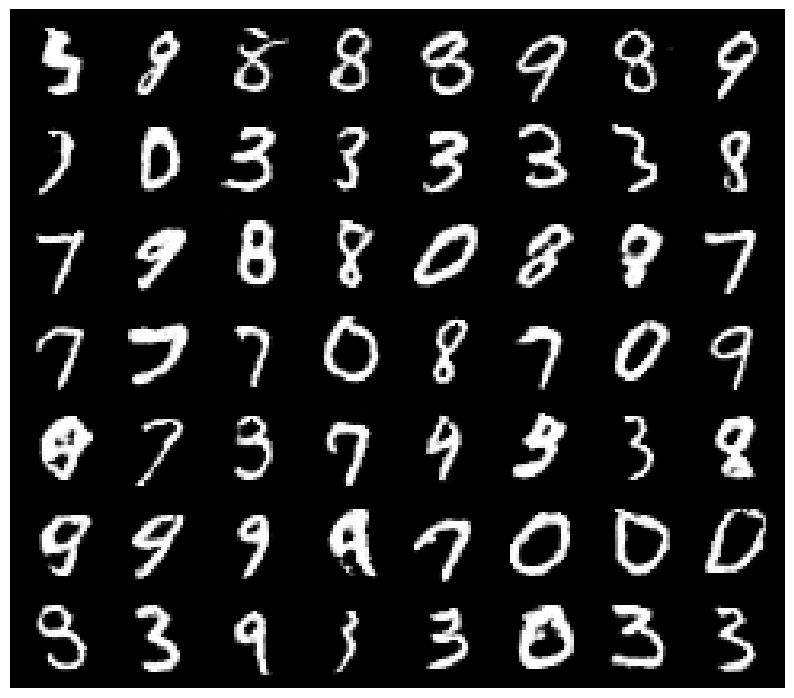

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.96it/s, loss_D=0.632, loss_G=2.11]


Epoch [62/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [62/400] - Average D loss: 0.6202, Average G loss: 2.0588


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.422, loss_G=2.48]


Epoch [63/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [63/400] - Average D loss: 0.6223, Average G loss: 2.0442


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.02it/s, loss_D=0.509, loss_G=2.06]


Epoch [64/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [64/400] - Average D loss: 0.6179, Average G loss: 2.0539


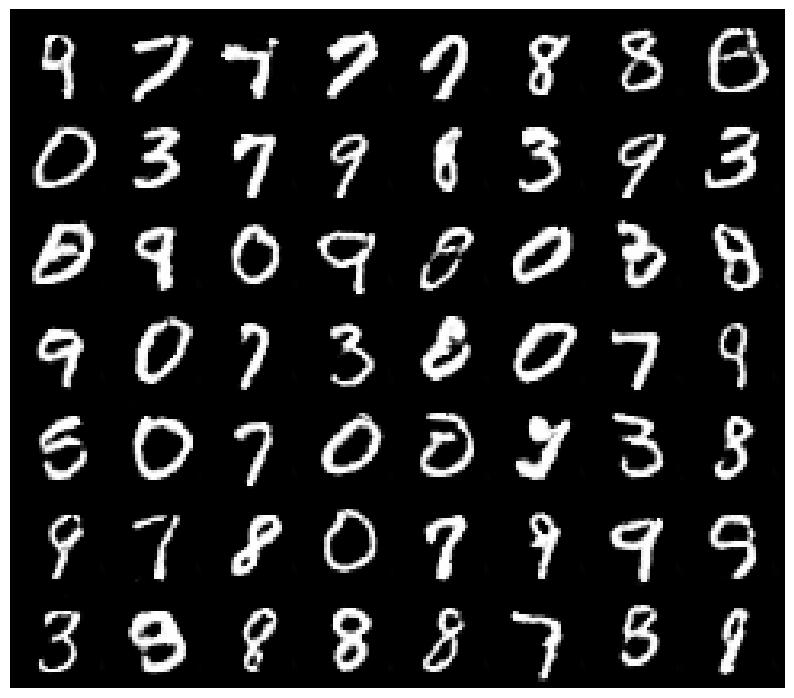

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.01it/s, loss_D=0.586, loss_G=1.66]


Epoch [65/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [65/400] - Average D loss: 0.6246, Average G loss: 2.0346


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.648, loss_G=2.1]


Epoch [66/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [66/400] - Average D loss: 0.6213, Average G loss: 2.0531


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.75it/s, loss_D=0.622, loss_G=2.06]


Epoch [67/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [67/400] - Average D loss: 0.6178, Average G loss: 2.0705


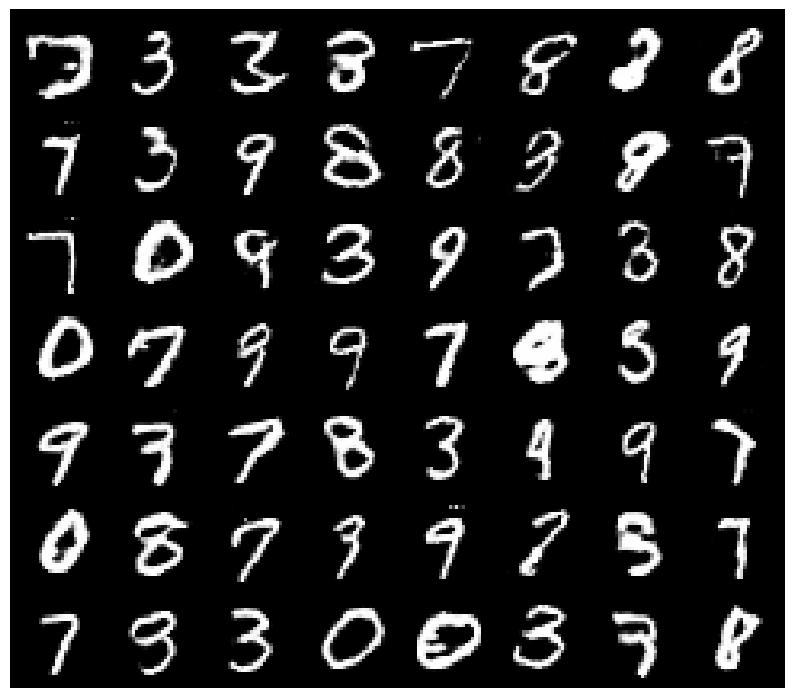

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.07it/s, loss_D=0.642, loss_G=2.31]


Epoch [68/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [68/400] - Average D loss: 0.6177, Average G loss: 2.0563


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.68it/s, loss_D=0.634, loss_G=1.87]


Epoch [69/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [69/400] - Average D loss: 0.6159, Average G loss: 2.0484


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.79it/s, loss_D=0.592, loss_G=2.22]


Epoch [70/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [70/400] - Average D loss: 0.6240, Average G loss: 2.0428


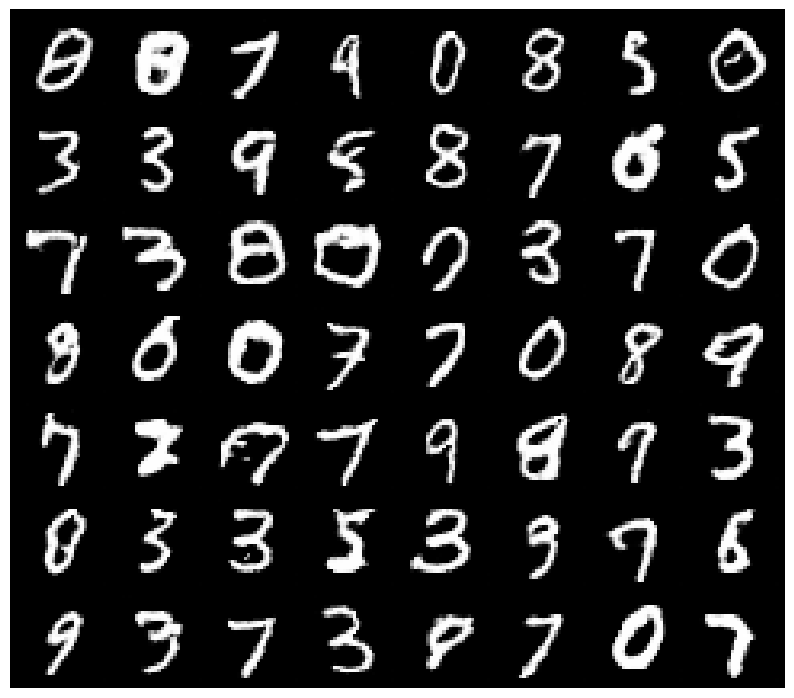

100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.78it/s, loss_D=0.726, loss_G=1.9]


Epoch [71/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [71/400] - Average D loss: 0.6223, Average G loss: 2.0422


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.57it/s, loss_D=0.529, loss_G=2.04]


Epoch [72/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [72/400] - Average D loss: 0.6154, Average G loss: 2.0620


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.02it/s, loss_D=0.634, loss_G=1.92]


Epoch [73/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [73/400] - Average D loss: 0.6129, Average G loss: 2.0625


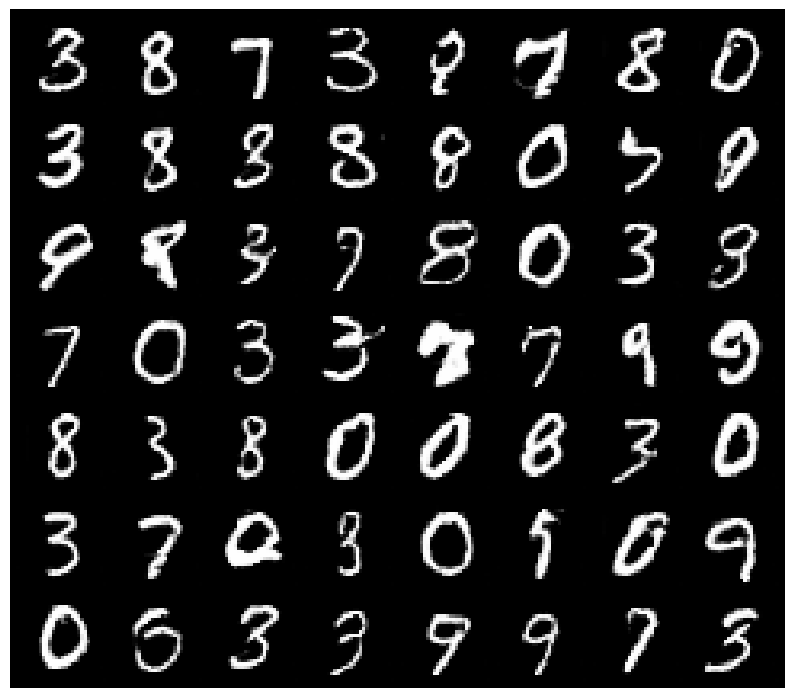

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.69it/s, loss_D=0.528, loss_G=2.53]


Epoch [74/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [74/400] - Average D loss: 0.6175, Average G loss: 2.0498


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.80it/s, loss_D=0.528, loss_G=2.25]


Epoch [75/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [75/400] - Average D loss: 0.6205, Average G loss: 2.0504


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.59it/s, loss_D=0.449, loss_G=2.26]


Epoch [76/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [76/400] - Average D loss: 0.6174, Average G loss: 2.0536


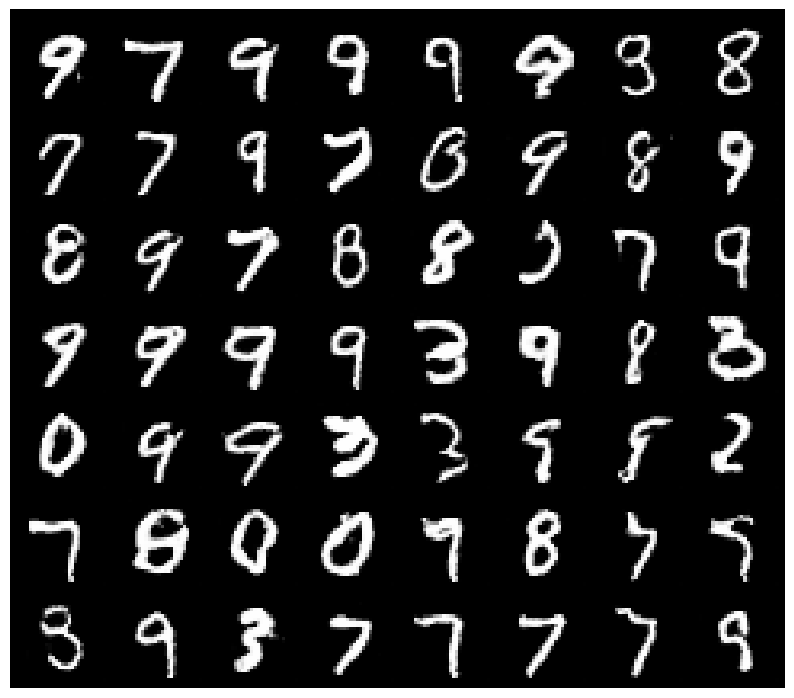

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.99it/s, loss_D=0.502, loss_G=2.18]


Epoch [77/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [77/400] - Average D loss: 0.6156, Average G loss: 2.0367


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.73it/s, loss_D=0.588, loss_G=2.27]


Epoch [78/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [78/400] - Average D loss: 0.6128, Average G loss: 2.0536


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.81it/s, loss_D=0.709, loss_G=2.13]


Epoch [79/400] - LR G: 0.0000524, LR D: 0.0000524
Epoch [79/400] - Average D loss: 0.6212, Average G loss: 2.0286


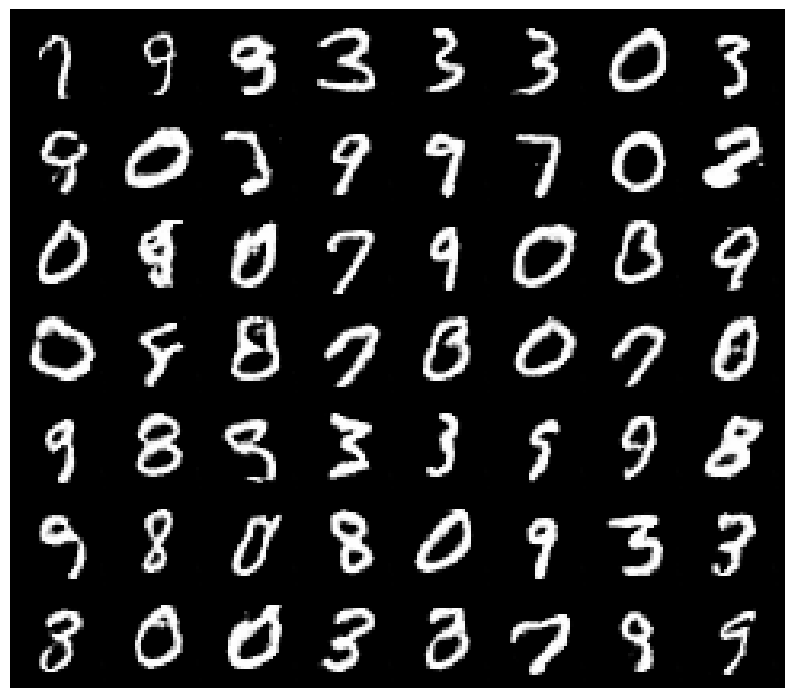

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.62it/s, loss_D=0.549, loss_G=2.03]


Epoch [80/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [80/400] - Average D loss: 0.6177, Average G loss: 2.0440


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.87it/s, loss_D=0.743, loss_G=1.99]


Epoch [81/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [81/400] - Average D loss: 0.6186, Average G loss: 2.0316


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.82it/s, loss_D=0.831, loss_G=2.14]


Epoch [82/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [82/400] - Average D loss: 0.6153, Average G loss: 2.0295


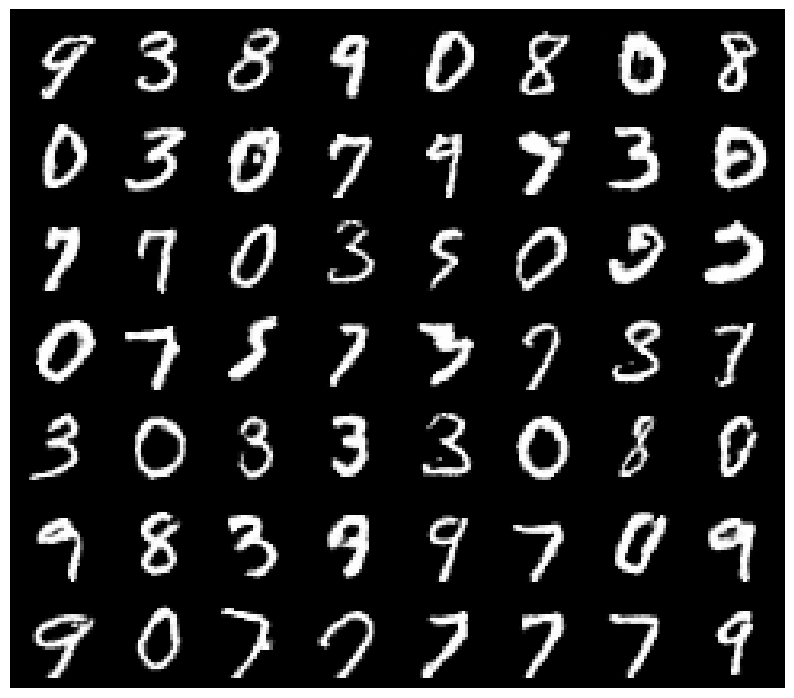

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.542, loss_G=2.03]


Epoch [83/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [83/400] - Average D loss: 0.6158, Average G loss: 2.0333


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.80it/s, loss_D=0.681, loss_G=1.94]


Epoch [84/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [84/400] - Average D loss: 0.6227, Average G loss: 2.0185


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.98it/s, loss_D=0.62, loss_G=1.81]


Epoch [85/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [85/400] - Average D loss: 0.6210, Average G loss: 2.0161


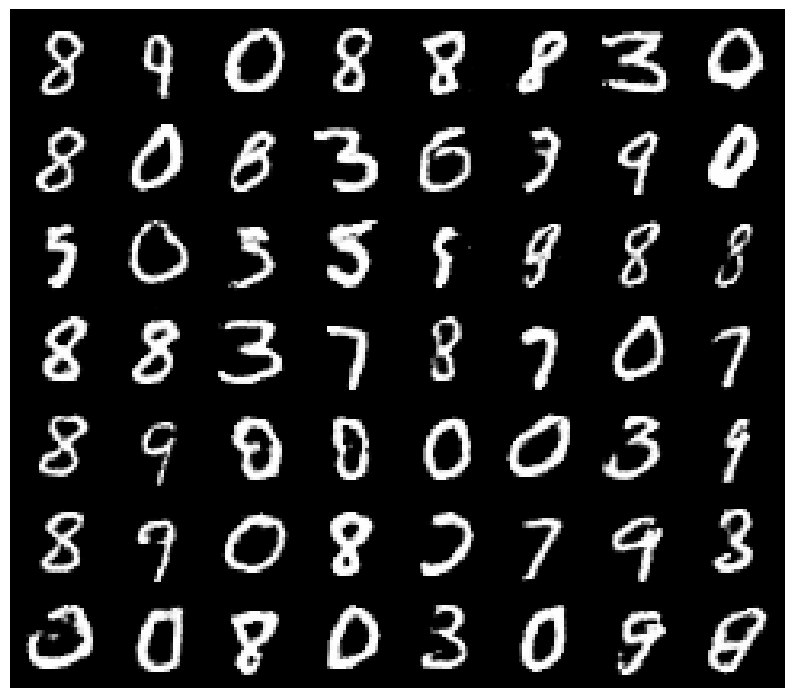

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.60it/s, loss_D=0.521, loss_G=1.98]


Epoch [86/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [86/400] - Average D loss: 0.6178, Average G loss: 2.0363


100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.68it/s, loss_D=0.47, loss_G=2.15]


Epoch [87/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [87/400] - Average D loss: 0.6149, Average G loss: 2.0334


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.594, loss_G=2.14]


Epoch [88/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [88/400] - Average D loss: 0.6179, Average G loss: 2.0272


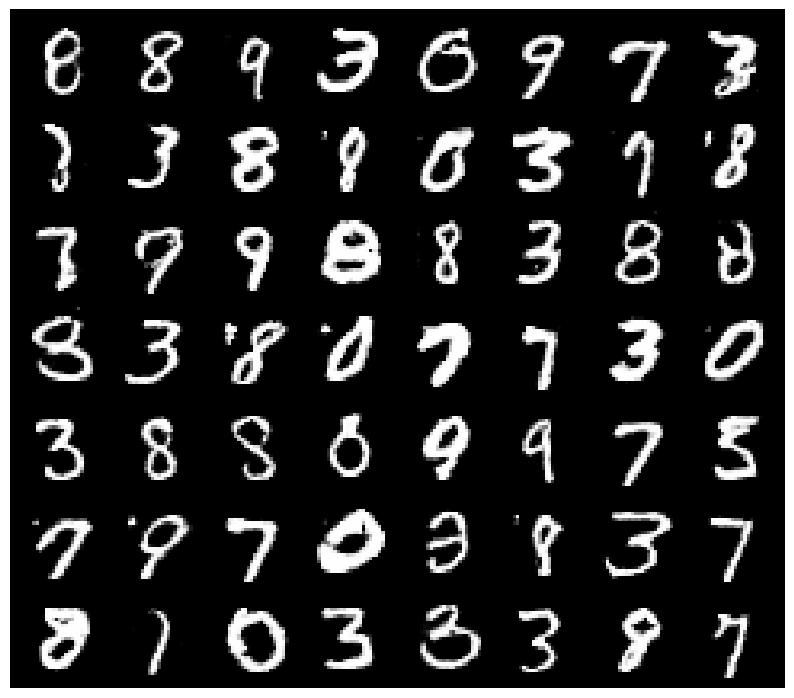

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.496, loss_G=1.86]


Epoch [89/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [89/400] - Average D loss: 0.6171, Average G loss: 2.0248


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.91it/s, loss_D=0.639, loss_G=1.81]


Epoch [90/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [90/400] - Average D loss: 0.6140, Average G loss: 2.0344


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.82it/s, loss_D=0.716, loss_G=2.01]


Epoch [91/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [91/400] - Average D loss: 0.6153, Average G loss: 2.0355


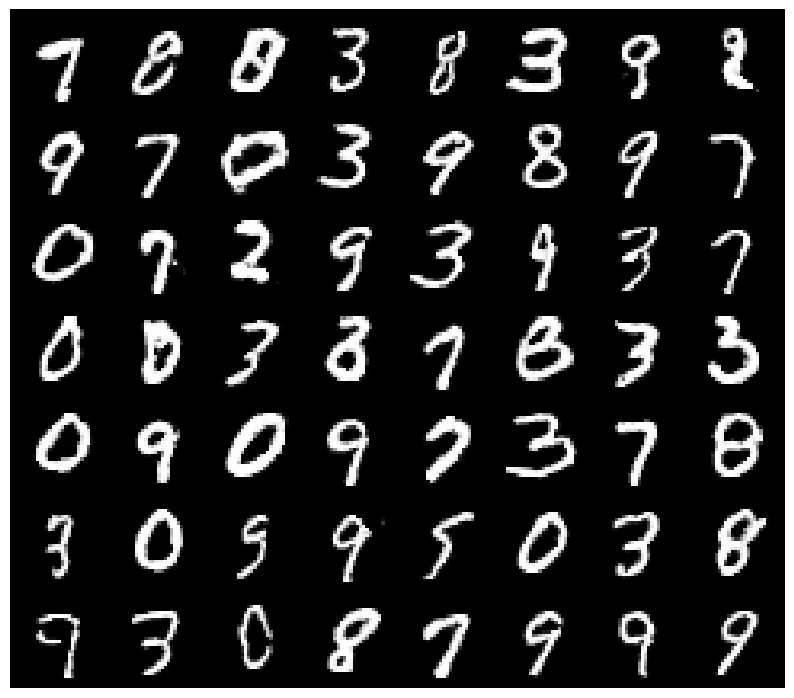

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.61, loss_G=1.99]


Epoch [92/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [92/400] - Average D loss: 0.6142, Average G loss: 2.0294


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.77it/s, loss_D=0.637, loss_G=1.97]


Epoch [93/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [93/400] - Average D loss: 0.6172, Average G loss: 2.0217


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.99it/s, loss_D=0.652, loss_G=1.93]


Epoch [94/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [94/400] - Average D loss: 0.6125, Average G loss: 2.0478


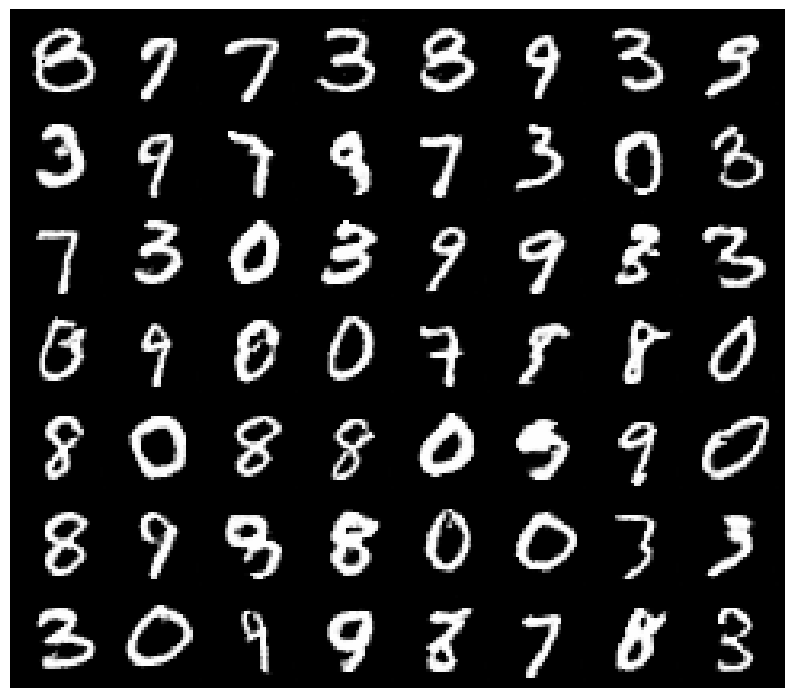

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.66it/s, loss_D=0.744, loss_G=1.92]


Epoch [95/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [95/400] - Average D loss: 0.6183, Average G loss: 2.0440


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.54it/s, loss_D=0.583, loss_G=2.12]


Epoch [96/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [96/400] - Average D loss: 0.6166, Average G loss: 2.0262


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.67it/s, loss_D=0.528, loss_G=1.98]


Epoch [97/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [97/400] - Average D loss: 0.6146, Average G loss: 2.0312


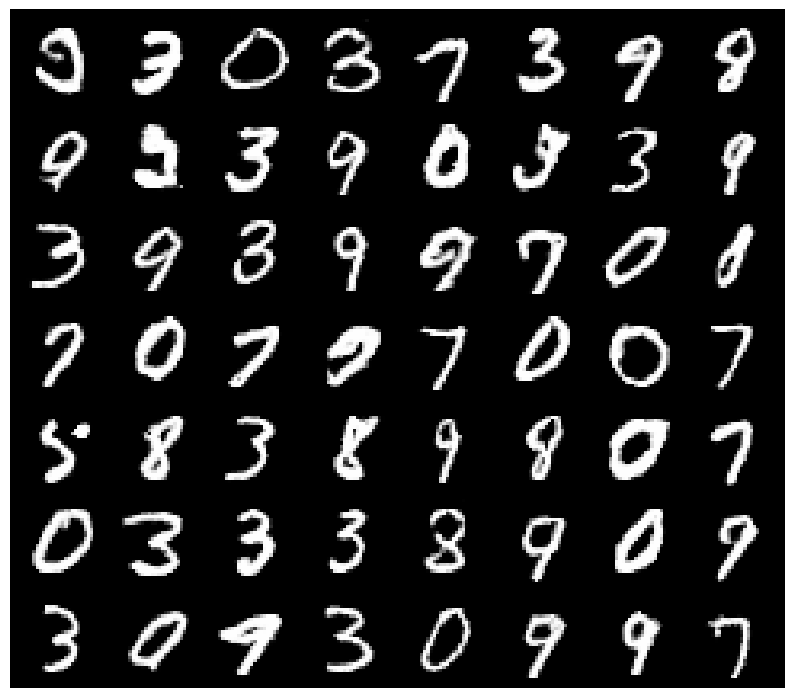

100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.71it/s, loss_D=0.836, loss_G=1.9]


Epoch [98/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [98/400] - Average D loss: 0.6134, Average G loss: 2.0307


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.07it/s, loss_D=0.578, loss_G=2.49]


Epoch [99/400] - LR G: 0.0000419, LR D: 0.0000419
Epoch [99/400] - Average D loss: 0.6098, Average G loss: 2.0396


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=0.613, loss_G=1.75]


Epoch [100/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [100/400] - Average D loss: 0.6089, Average G loss: 2.0503


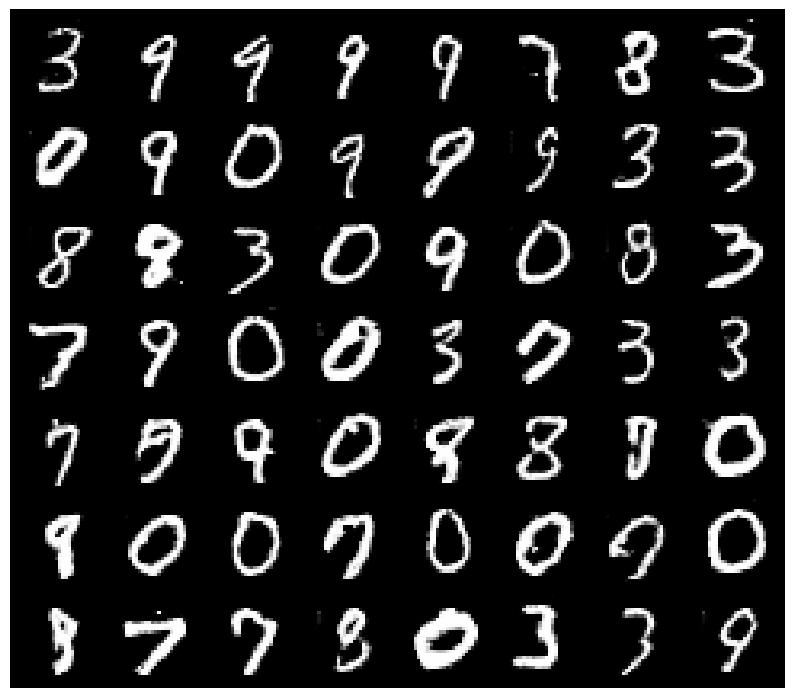

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.11it/s, loss_D=0.667, loss_G=1.87]


Epoch [101/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [101/400] - Average D loss: 0.6115, Average G loss: 2.0363


100%|███████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.83it/s, loss_D=0.6, loss_G=1.81]


Epoch [102/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [102/400] - Average D loss: 0.6076, Average G loss: 2.0410


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.03it/s, loss_D=0.608, loss_G=2.06]


Epoch [103/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [103/400] - Average D loss: 0.6144, Average G loss: 2.0402


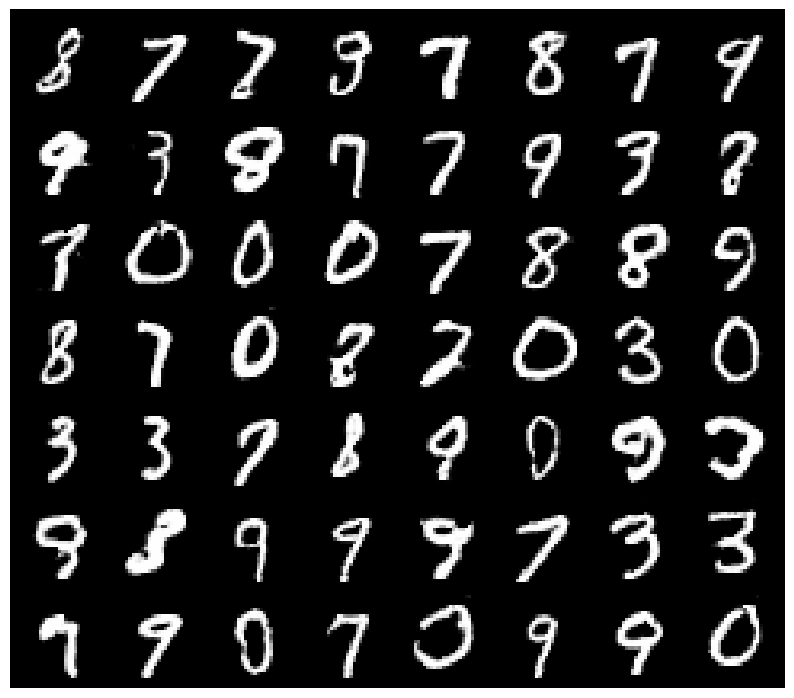

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.86it/s, loss_D=0.41, loss_G=1.93]


Epoch [104/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [104/400] - Average D loss: 0.6087, Average G loss: 2.0321


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.695, loss_G=2.02]


Epoch [105/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [105/400] - Average D loss: 0.6102, Average G loss: 2.0299


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.68it/s, loss_D=0.553, loss_G=2.14]


Epoch [106/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [106/400] - Average D loss: 0.6074, Average G loss: 2.0377


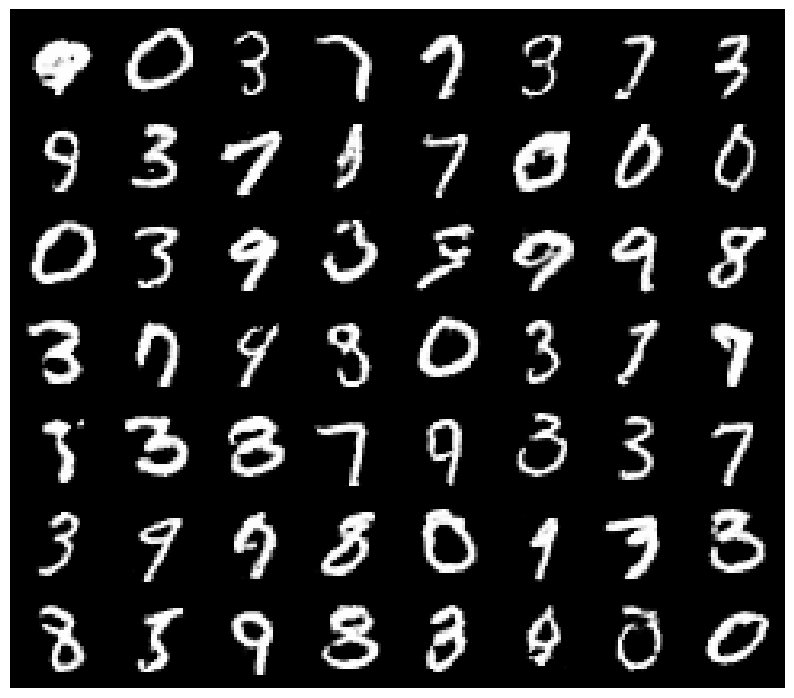

100%|████████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.552, loss_G=2]


Epoch [107/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [107/400] - Average D loss: 0.6093, Average G loss: 2.0319


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.82it/s, loss_D=0.749, loss_G=1.87]


Epoch [108/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [108/400] - Average D loss: 0.6051, Average G loss: 2.0569


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.16it/s, loss_D=0.638, loss_G=2.13]


Epoch [109/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [109/400] - Average D loss: 0.6072, Average G loss: 2.0506


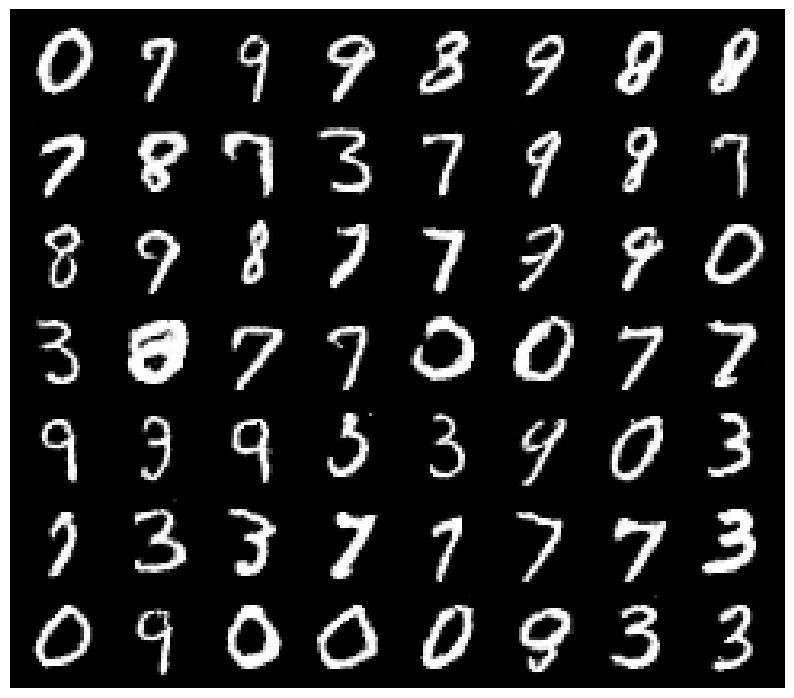

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.30it/s, loss_D=0.557, loss_G=2.21]


Epoch [110/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [110/400] - Average D loss: 0.6036, Average G loss: 2.0452


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.08it/s, loss_D=0.657, loss_G=1.94]


Epoch [111/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [111/400] - Average D loss: 0.6065, Average G loss: 2.0385


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.87it/s, loss_D=0.509, loss_G=2.25]


Epoch [112/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [112/400] - Average D loss: 0.6063, Average G loss: 2.0481


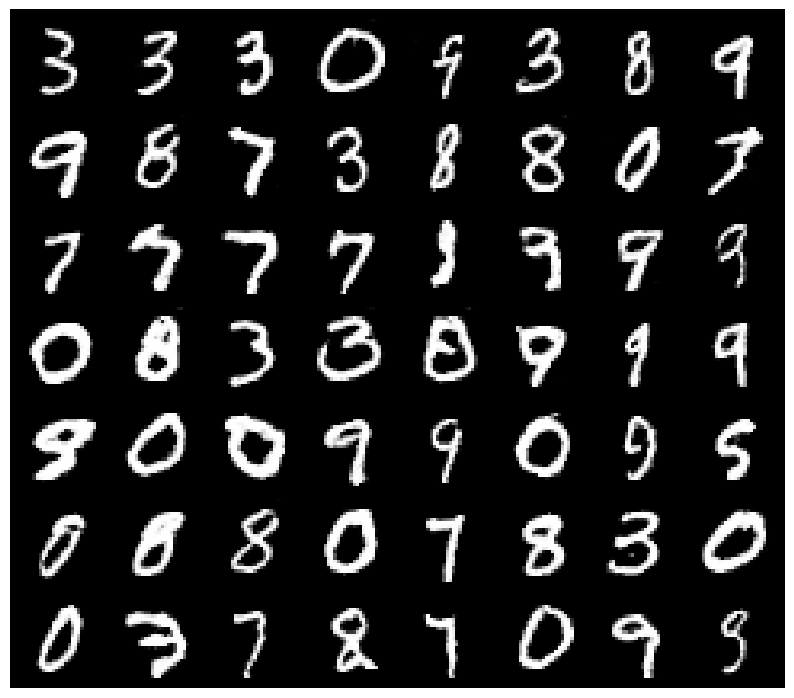

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.79it/s, loss_D=0.485, loss_G=2.18]


Epoch [113/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [113/400] - Average D loss: 0.6058, Average G loss: 2.0349


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.53it/s, loss_D=0.616, loss_G=1.92]


Epoch [114/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [114/400] - Average D loss: 0.6040, Average G loss: 2.0463


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.96it/s, loss_D=0.427, loss_G=2.52]


Epoch [115/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [115/400] - Average D loss: 0.6010, Average G loss: 2.0588


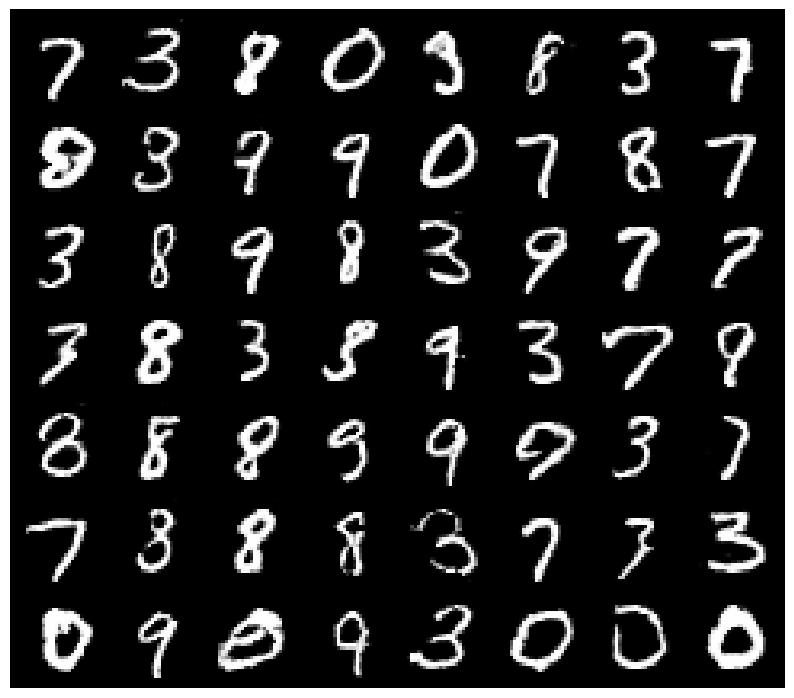

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.14it/s, loss_D=0.527, loss_G=2.07]


Epoch [116/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [116/400] - Average D loss: 0.6018, Average G loss: 2.0658


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.00it/s, loss_D=0.789, loss_G=2.02]


Epoch [117/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [117/400] - Average D loss: 0.6083, Average G loss: 2.0695


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.74it/s, loss_D=0.776, loss_G=2.08]


Epoch [118/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [118/400] - Average D loss: 0.6041, Average G loss: 2.0560


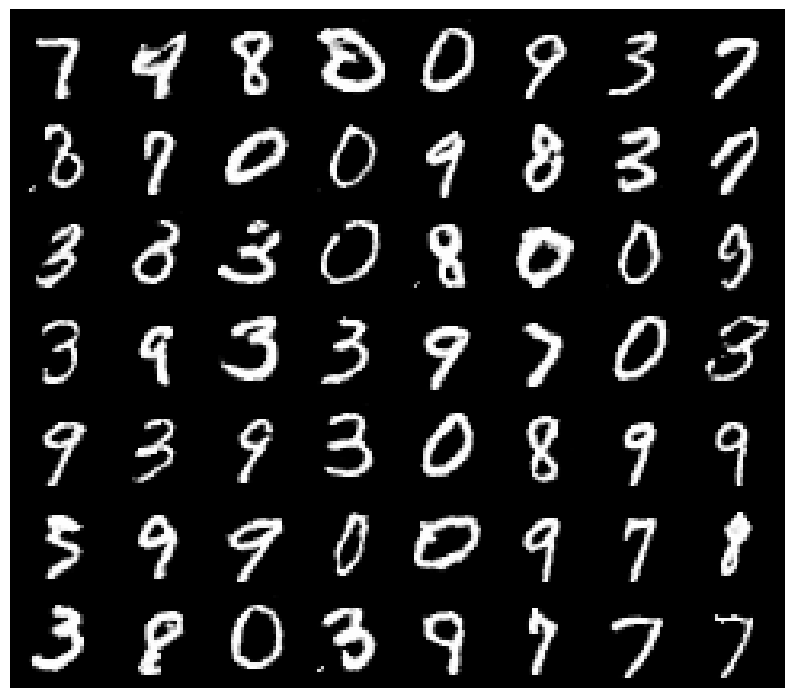

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.71it/s, loss_D=0.523, loss_G=2.12]


Epoch [119/400] - LR G: 0.0000336, LR D: 0.0000336
Epoch [119/400] - Average D loss: 0.5966, Average G loss: 2.0686


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.64it/s, loss_D=0.689, loss_G=1.88]


Epoch [120/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [120/400] - Average D loss: 0.5954, Average G loss: 2.0811


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.75it/s, loss_D=0.441, loss_G=2.15]


Epoch [121/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [121/400] - Average D loss: 0.6039, Average G loss: 2.0571


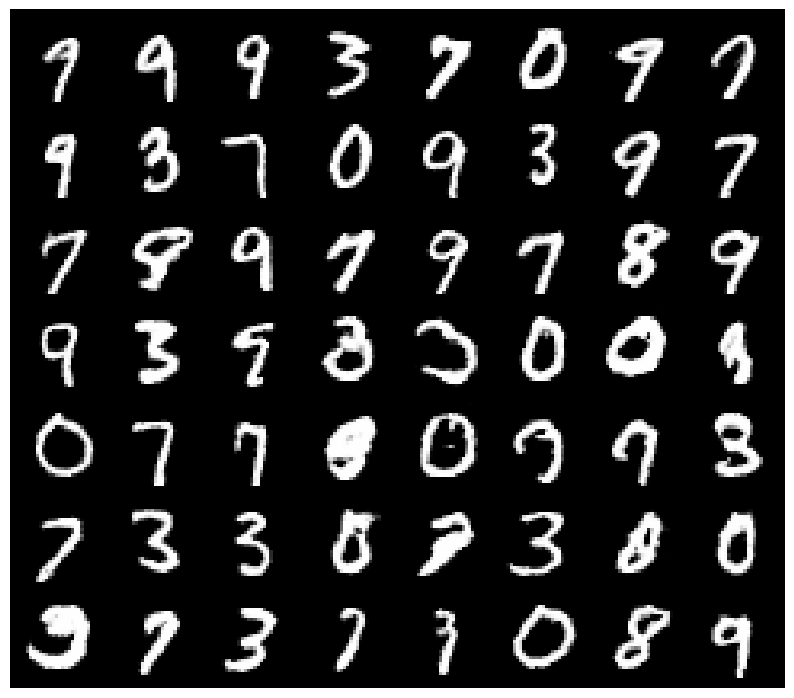

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.12it/s, loss_D=0.528, loss_G=1.84]


Epoch [122/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [122/400] - Average D loss: 0.6007, Average G loss: 2.0504


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.61it/s, loss_D=0.689, loss_G=1.87]


Epoch [123/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [123/400] - Average D loss: 0.5958, Average G loss: 2.0650


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.601, loss_G=2.05]


Epoch [124/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [124/400] - Average D loss: 0.6019, Average G loss: 2.0465


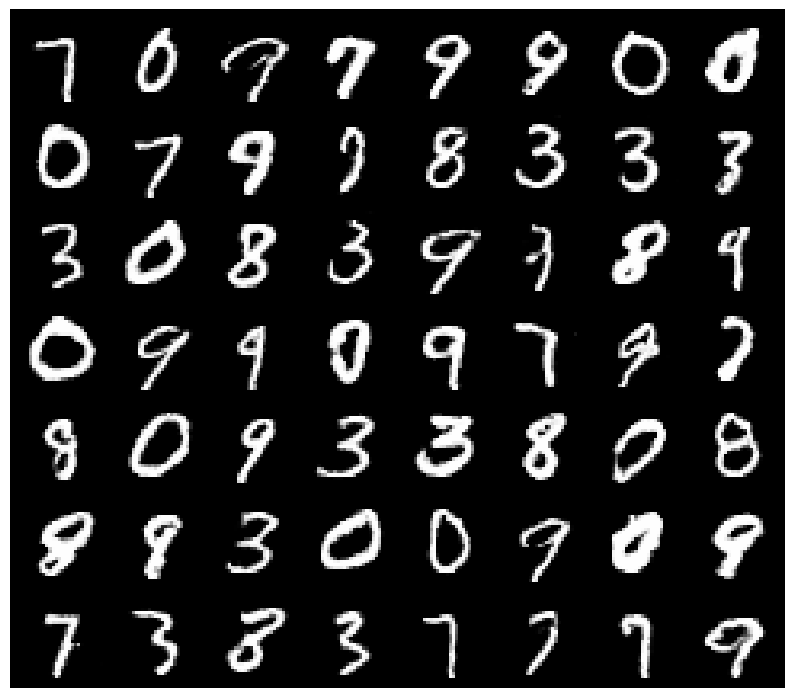

100%|████████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.642, loss_G=2]


Epoch [125/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [125/400] - Average D loss: 0.6025, Average G loss: 2.0469


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.655, loss_G=2.02]


Epoch [126/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [126/400] - Average D loss: 0.5999, Average G loss: 2.0578


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.76it/s, loss_D=0.414, loss_G=2.35]


Epoch [127/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [127/400] - Average D loss: 0.5981, Average G loss: 2.0532


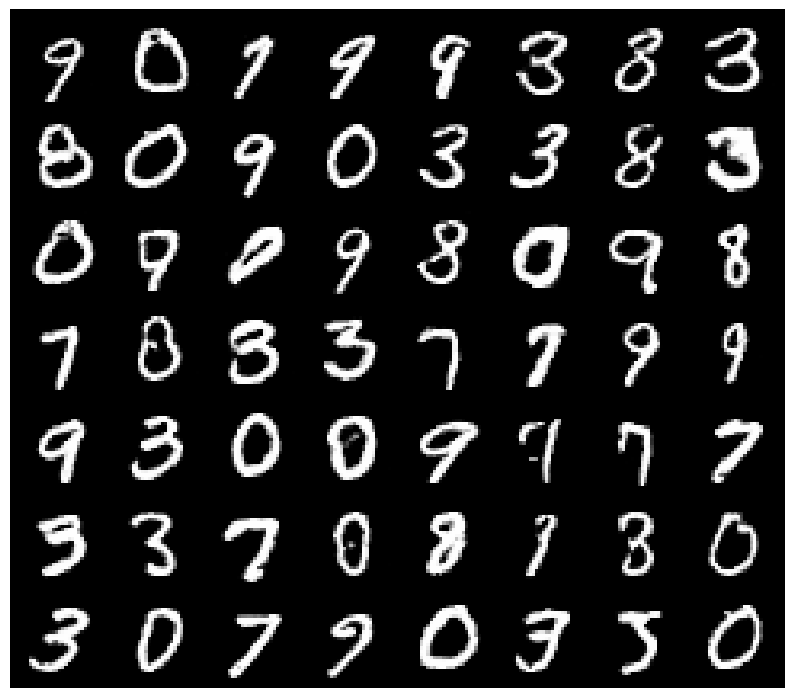

100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.75it/s, loss_D=0.57, loss_G=2.11]


Epoch [128/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [128/400] - Average D loss: 0.5991, Average G loss: 2.0591


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.62it/s, loss_D=0.555, loss_G=2.05]


Epoch [129/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [129/400] - Average D loss: 0.6000, Average G loss: 2.0597


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.78it/s, loss_D=0.602, loss_G=1.88]


Epoch [130/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [130/400] - Average D loss: 0.5995, Average G loss: 2.0616


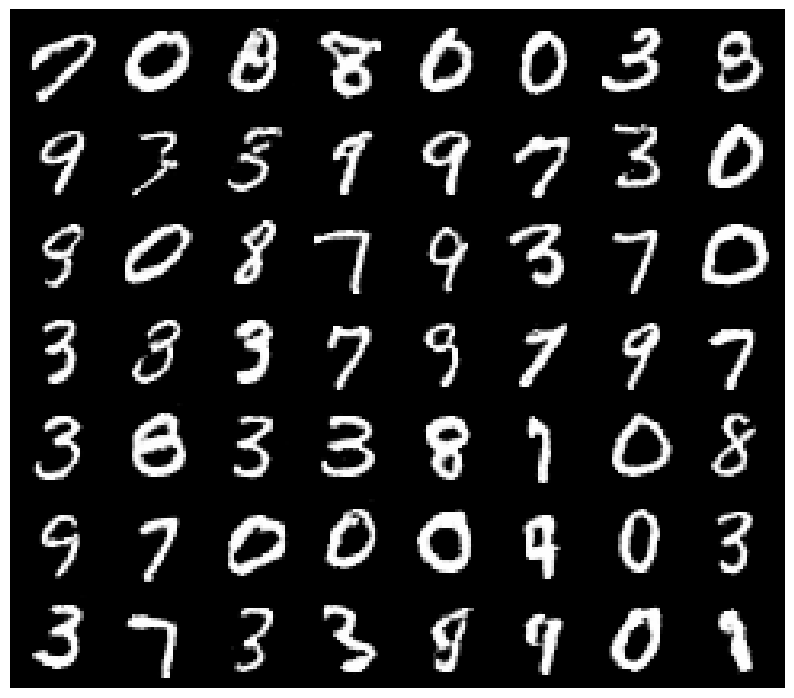

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.774, loss_G=1.82]


Epoch [131/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [131/400] - Average D loss: 0.5961, Average G loss: 2.0741


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.02it/s, loss_D=0.698, loss_G=2.12]


Epoch [132/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [132/400] - Average D loss: 0.5985, Average G loss: 2.0633


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.92it/s, loss_D=0.417, loss_G=2.01]


Epoch [133/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [133/400] - Average D loss: 0.5929, Average G loss: 2.0854


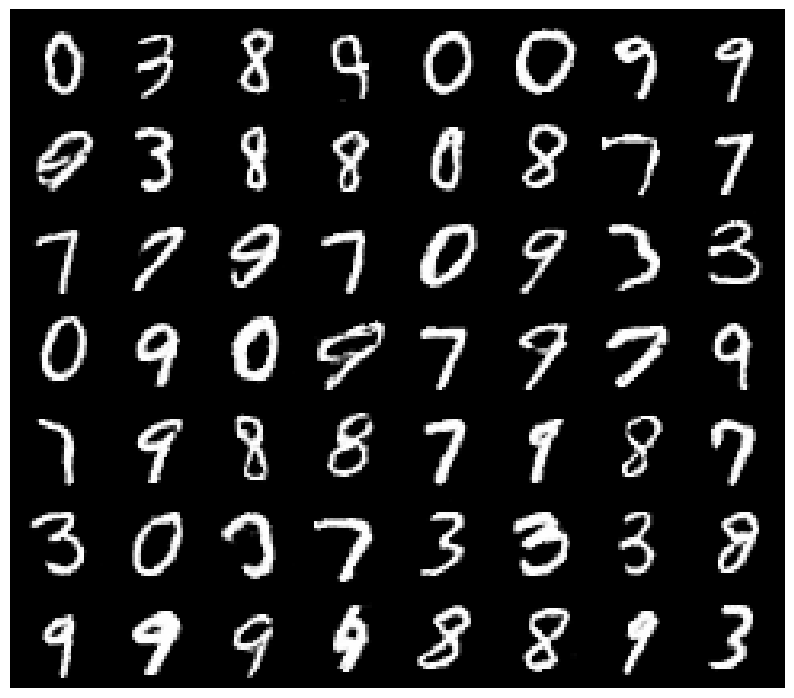

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.56it/s, loss_D=0.503, loss_G=2.12]


Epoch [134/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [134/400] - Average D loss: 0.5957, Average G loss: 2.0617


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.66it/s, loss_D=0.481, loss_G=2.02]


Epoch [135/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [135/400] - Average D loss: 0.6006, Average G loss: 2.0724


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.73it/s, loss_D=0.597, loss_G=2.13]


Epoch [136/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [136/400] - Average D loss: 0.5963, Average G loss: 2.0671


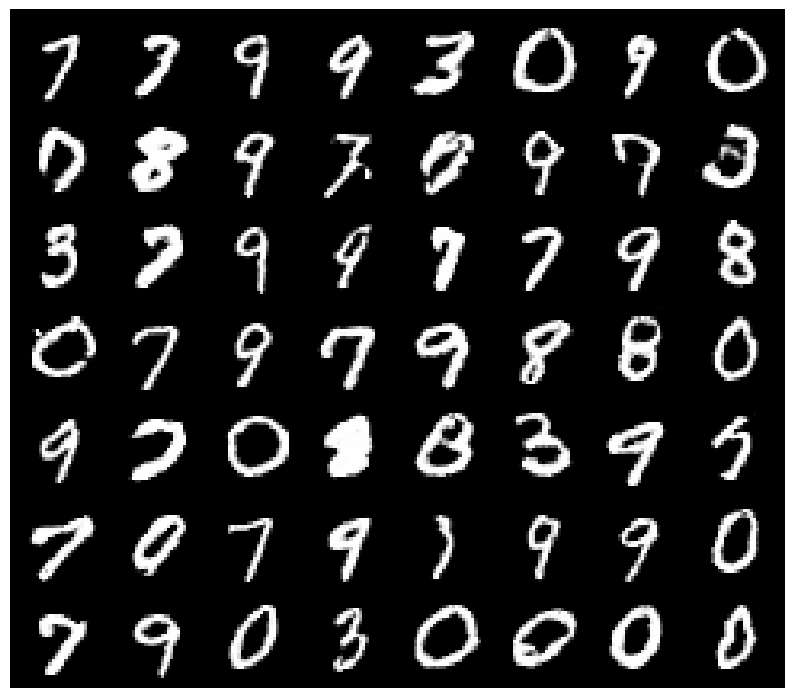

100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.78it/s, loss_D=0.53, loss_G=2.35]


Epoch [137/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [137/400] - Average D loss: 0.6010, Average G loss: 2.0568


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.96it/s, loss_D=0.642, loss_G=1.97]


Epoch [138/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [138/400] - Average D loss: 0.5917, Average G loss: 2.0817


100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.08it/s, loss_D=0.56, loss_G=2.25]


Epoch [139/400] - LR G: 0.0000268, LR D: 0.0000268
Epoch [139/400] - Average D loss: 0.5982, Average G loss: 2.0675


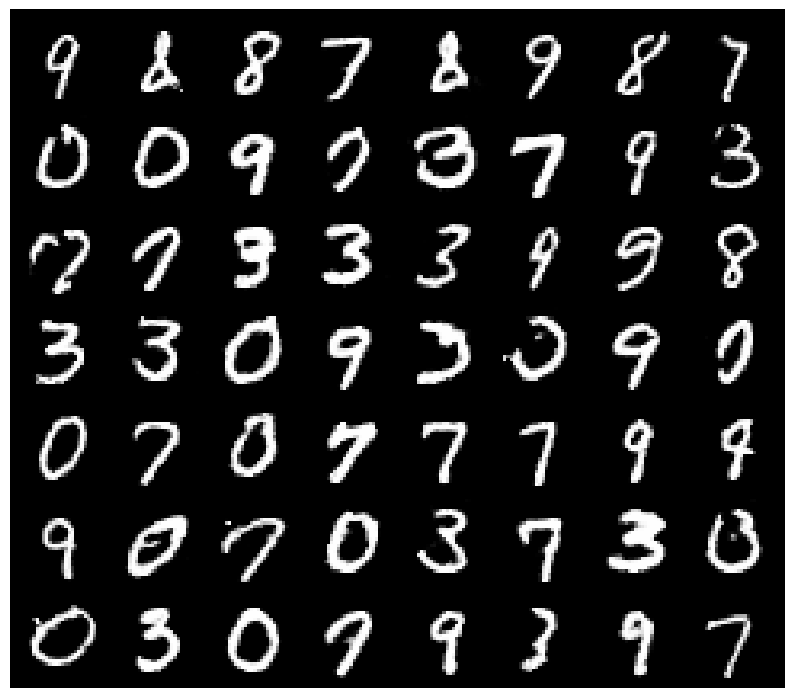

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.65it/s, loss_D=0.667, loss_G=1.97]


Epoch [140/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [140/400] - Average D loss: 0.5963, Average G loss: 2.0632


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.537, loss_G=2.48]


Epoch [141/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [141/400] - Average D loss: 0.5952, Average G loss: 2.0608


100%|███████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.89it/s, loss_D=0.57, loss_G=2.2]


Epoch [142/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [142/400] - Average D loss: 0.5940, Average G loss: 2.0663


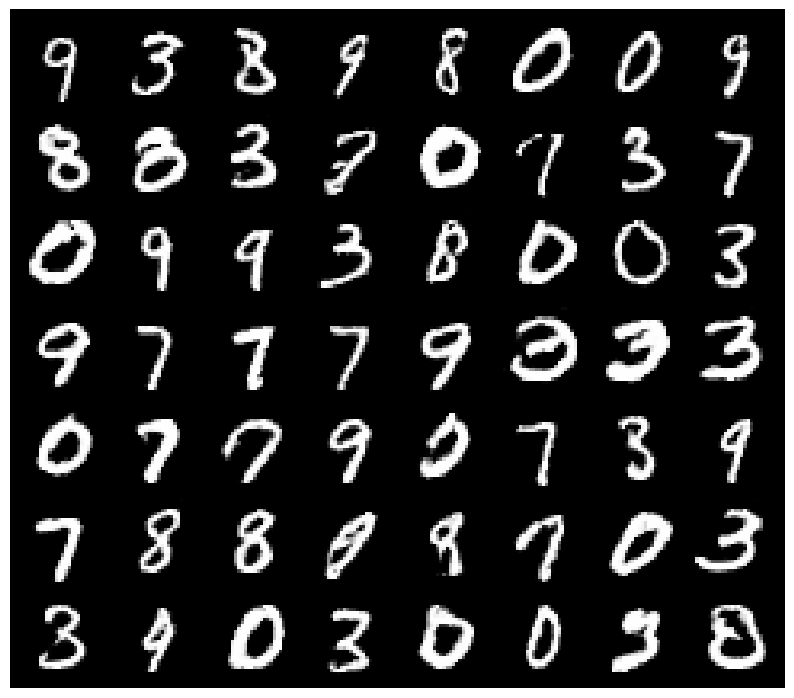

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.543, loss_G=1.85]


Epoch [143/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [143/400] - Average D loss: 0.5970, Average G loss: 2.0562


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.574, loss_G=2.02]


Epoch [144/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [144/400] - Average D loss: 0.5954, Average G loss: 2.0636


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.98it/s, loss_D=0.577, loss_G=2.01]


Epoch [145/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [145/400] - Average D loss: 0.5963, Average G loss: 2.0541


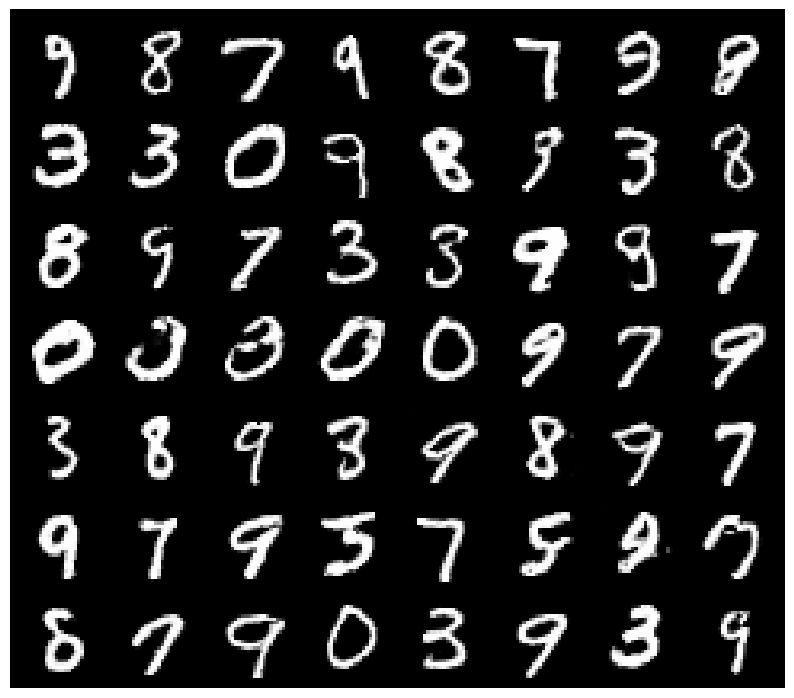

100%|██████████████████████████████████████████████████████| 732/732 [01:09<00:00, 10.59it/s, loss_D=0.586, loss_G=2.1]


Epoch [146/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [146/400] - Average D loss: 0.5951, Average G loss: 2.0567


100%|███████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.64it/s, loss_D=0.67, loss_G=1.8]


Epoch [147/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [147/400] - Average D loss: 0.5955, Average G loss: 2.0706


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.14it/s, loss_D=0.528, loss_G=2.06]


Epoch [148/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [148/400] - Average D loss: 0.5921, Average G loss: 2.0664


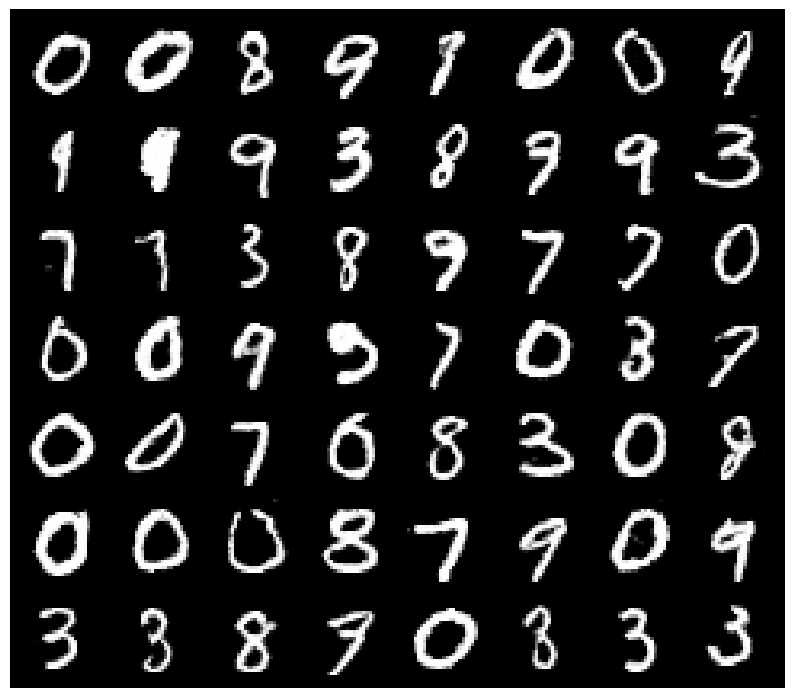

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=0.604, loss_G=2.4]


Epoch [149/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [149/400] - Average D loss: 0.5939, Average G loss: 2.0670


100%|████████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.89it/s, loss_D=0.542, loss_G=2]


Epoch [150/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [150/400] - Average D loss: 0.5938, Average G loss: 2.0687


100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.81it/s, loss_D=0.82, loss_G=2.18]


Epoch [151/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [151/400] - Average D loss: 0.5924, Average G loss: 2.0687


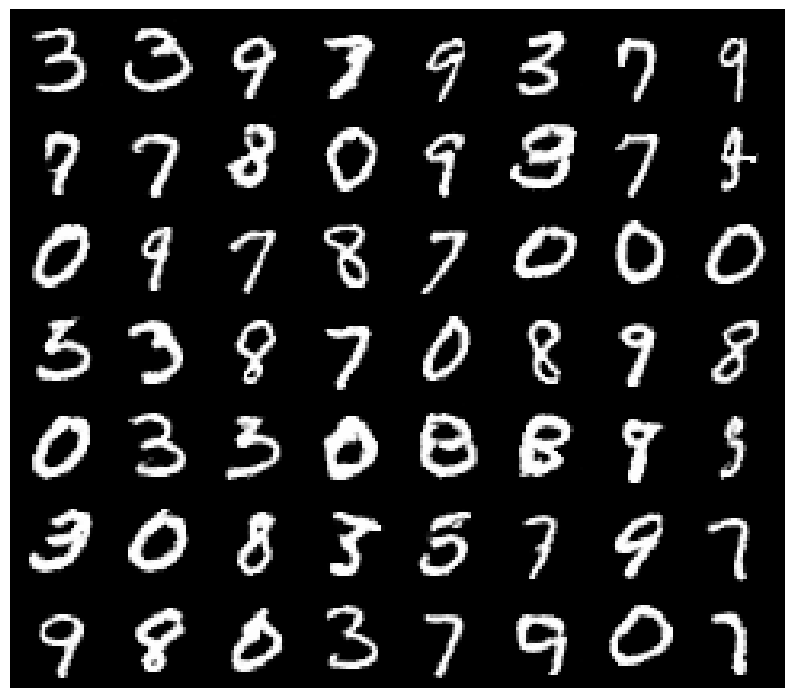

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.00it/s, loss_D=0.67, loss_G=2.27]


Epoch [152/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [152/400] - Average D loss: 0.5923, Average G loss: 2.0784


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.95it/s, loss_D=0.551, loss_G=2.18]


Epoch [153/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [153/400] - Average D loss: 0.5959, Average G loss: 2.0689


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.692, loss_G=1.9]


Epoch [154/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [154/400] - Average D loss: 0.5956, Average G loss: 2.0686


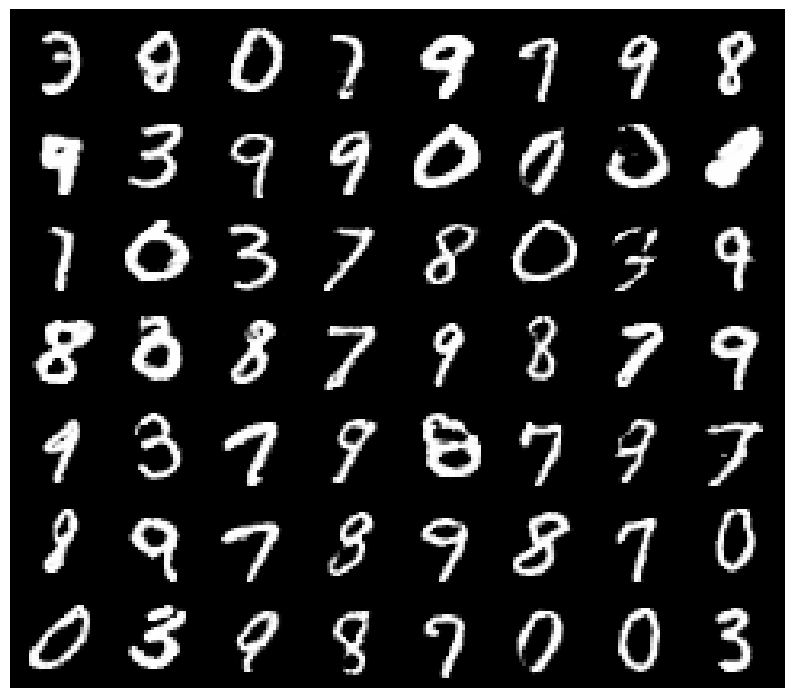

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.77it/s, loss_D=0.613, loss_G=2.13]


Epoch [155/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [155/400] - Average D loss: 0.5959, Average G loss: 2.0625


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.57it/s, loss_D=0.492, loss_G=2.05]


Epoch [156/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [156/400] - Average D loss: 0.5900, Average G loss: 2.0716


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.53it/s, loss_D=0.531, loss_G=2.01]


Epoch [157/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [157/400] - Average D loss: 0.5910, Average G loss: 2.0733


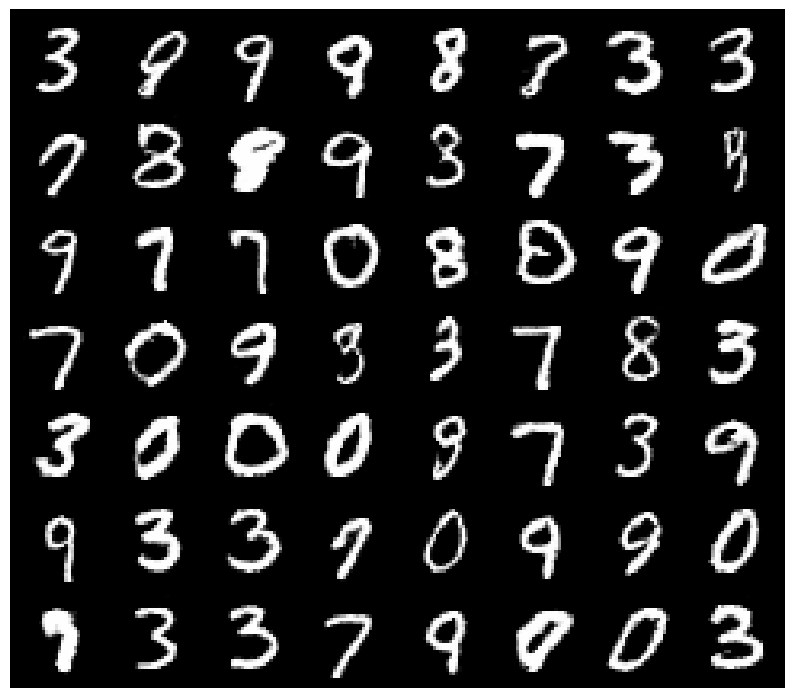

100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.69it/s, loss_D=0.636, loss_G=2.1]


Epoch [158/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [158/400] - Average D loss: 0.5913, Average G loss: 2.0853


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.48it/s, loss_D=0.621, loss_G=2.04]


Epoch [159/400] - LR G: 0.0000215, LR D: 0.0000215
Epoch [159/400] - Average D loss: 0.5905, Average G loss: 2.0782


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=0.546, loss_G=2.32]


Epoch [160/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [160/400] - Average D loss: 0.5910, Average G loss: 2.0905


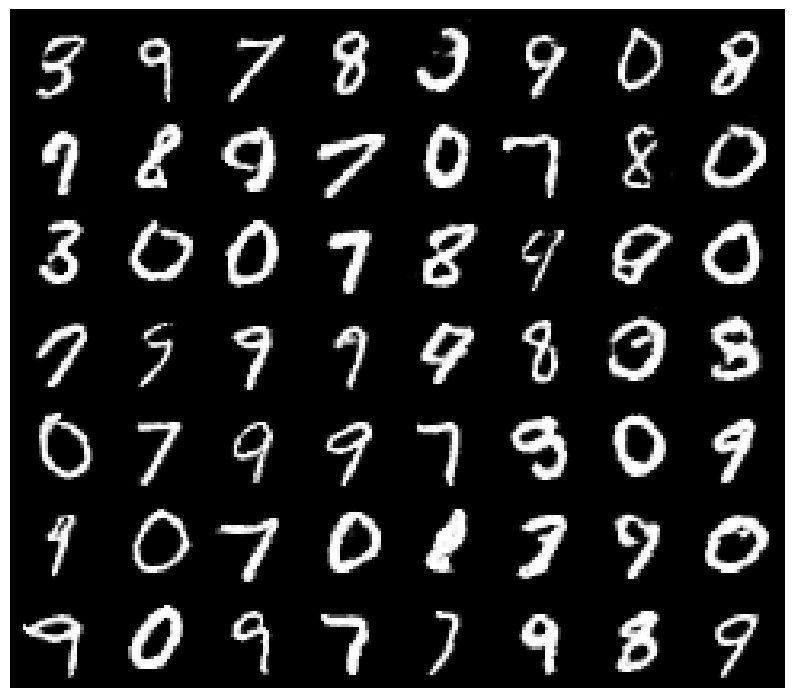

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.24it/s, loss_D=0.543, loss_G=2.26]


Epoch [161/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [161/400] - Average D loss: 0.5915, Average G loss: 2.0734


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.39it/s, loss_D=0.532, loss_G=2.07]


Epoch [162/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [162/400] - Average D loss: 0.5895, Average G loss: 2.0700


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.47it/s, loss_D=0.454, loss_G=2.49]


Epoch [163/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [163/400] - Average D loss: 0.5834, Average G loss: 2.0812


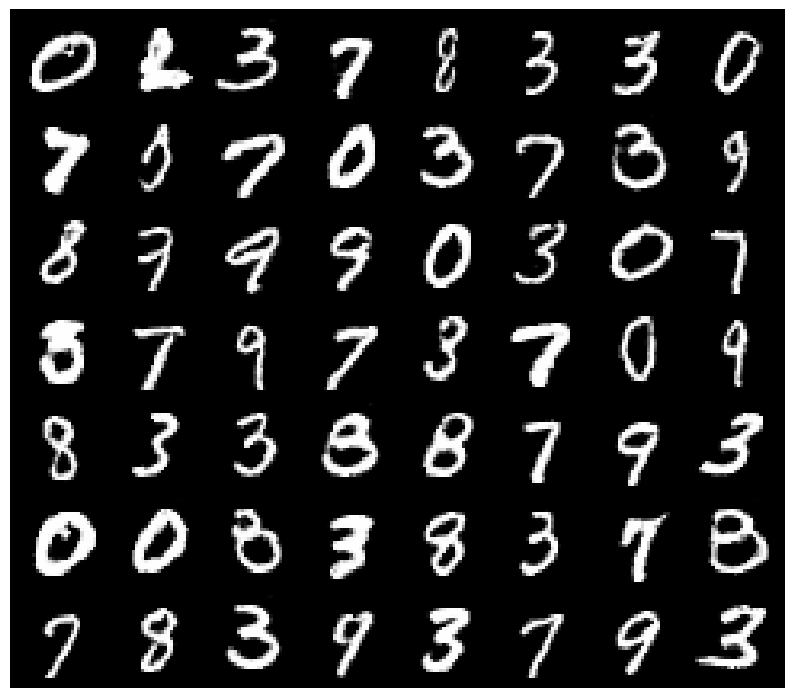

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.14it/s, loss_D=0.679, loss_G=1.92]


Epoch [164/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [164/400] - Average D loss: 0.5922, Average G loss: 2.0771


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.22it/s, loss_D=0.756, loss_G=1.94]


Epoch [165/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [165/400] - Average D loss: 0.5934, Average G loss: 2.0747


100%|██████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.46it/s, loss_D=0.72, loss_G=2.01]


Epoch [166/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [166/400] - Average D loss: 0.5915, Average G loss: 2.0747


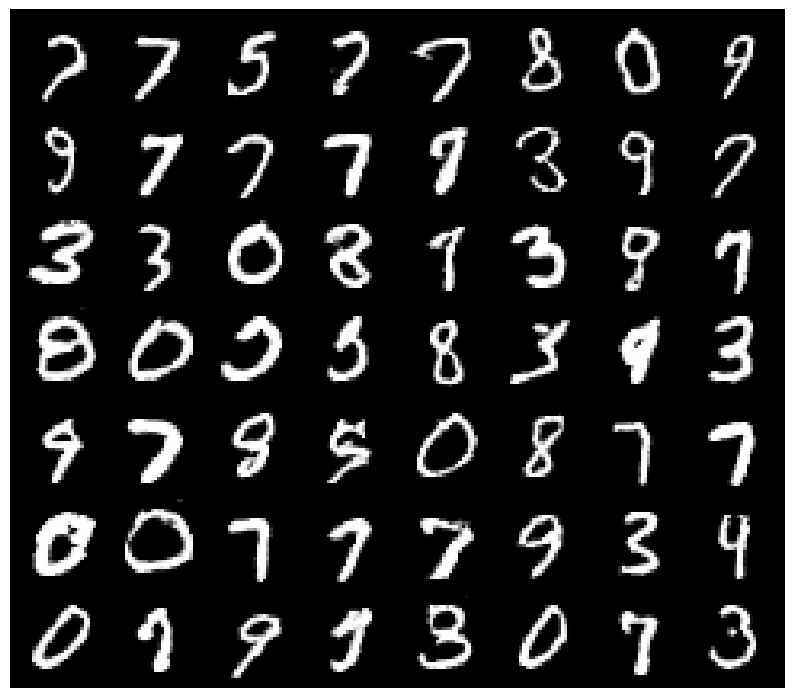

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.24it/s, loss_D=0.511, loss_G=1.89]


Epoch [167/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [167/400] - Average D loss: 0.5884, Average G loss: 2.0809


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.17it/s, loss_D=0.633, loss_G=2.07]


Epoch [168/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [168/400] - Average D loss: 0.5909, Average G loss: 2.0771


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.17it/s, loss_D=0.522, loss_G=1.95]


Epoch [169/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [169/400] - Average D loss: 0.5907, Average G loss: 2.0710


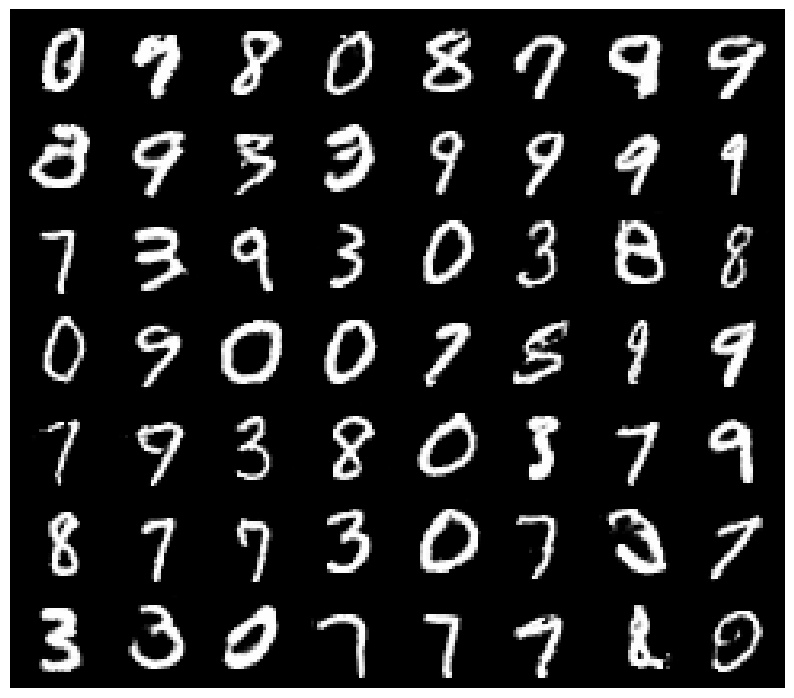

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.29it/s, loss_D=0.655, loss_G=1.89]


Epoch [170/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [170/400] - Average D loss: 0.5873, Average G loss: 2.0861


100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 13.03it/s, loss_D=0.625, loss_G=2.39]


Epoch [171/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [171/400] - Average D loss: 0.5907, Average G loss: 2.0883


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.10it/s, loss_D=0.574, loss_G=1.82]


Epoch [172/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [172/400] - Average D loss: 0.5859, Average G loss: 2.0826


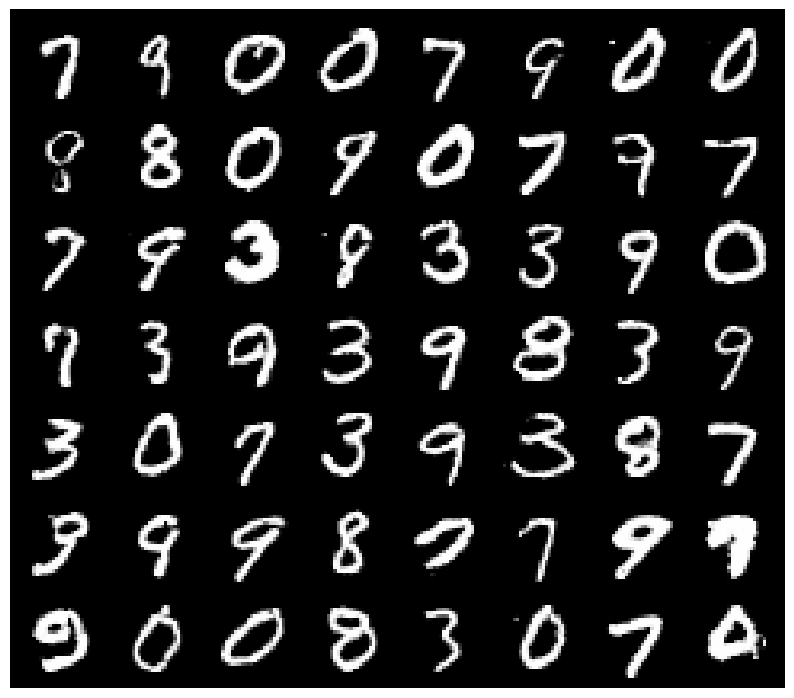

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.31it/s, loss_D=0.674, loss_G=1.94]


Epoch [173/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [173/400] - Average D loss: 0.5879, Average G loss: 2.0783


100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 12.90it/s, loss_D=0.571, loss_G=2.13]


Epoch [174/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [174/400] - Average D loss: 0.5872, Average G loss: 2.0907


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.18it/s, loss_D=0.526, loss_G=2.09]


Epoch [175/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [175/400] - Average D loss: 0.5857, Average G loss: 2.0847


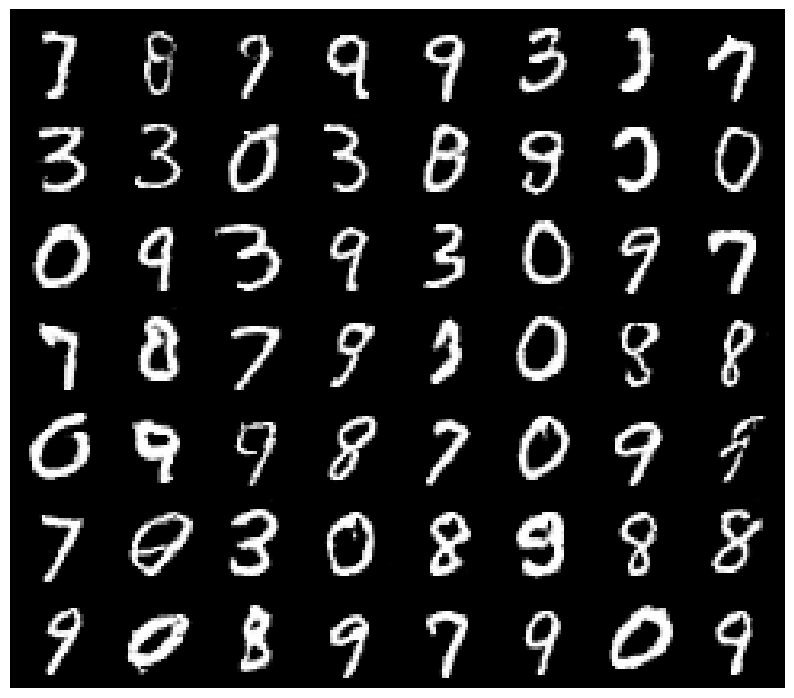

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.19it/s, loss_D=0.626, loss_G=1.95]


Epoch [176/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [176/400] - Average D loss: 0.5899, Average G loss: 2.0778


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.15it/s, loss_D=0.674, loss_G=1.89]


Epoch [177/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [177/400] - Average D loss: 0.5889, Average G loss: 2.0773


100%|████████████████████████████████████████████████████████| 732/732 [00:56<00:00, 13.02it/s, loss_D=0.707, loss_G=2]


Epoch [178/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [178/400] - Average D loss: 0.5875, Average G loss: 2.0893


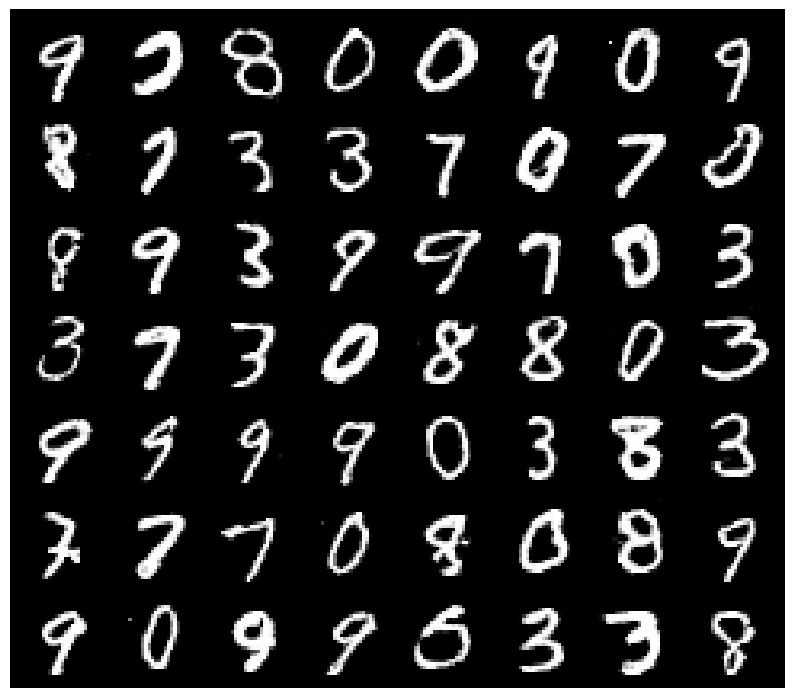

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.19it/s, loss_D=0.482, loss_G=2.35]


Epoch [179/400] - LR G: 0.0000172, LR D: 0.0000172
Epoch [179/400] - Average D loss: 0.5881, Average G loss: 2.0783


100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 13.00it/s, loss_D=0.597, loss_G=1.95]


Epoch [180/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [180/400] - Average D loss: 0.5857, Average G loss: 2.0880


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.15it/s, loss_D=0.441, loss_G=2.47]


Epoch [181/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [181/400] - Average D loss: 0.5851, Average G loss: 2.0945


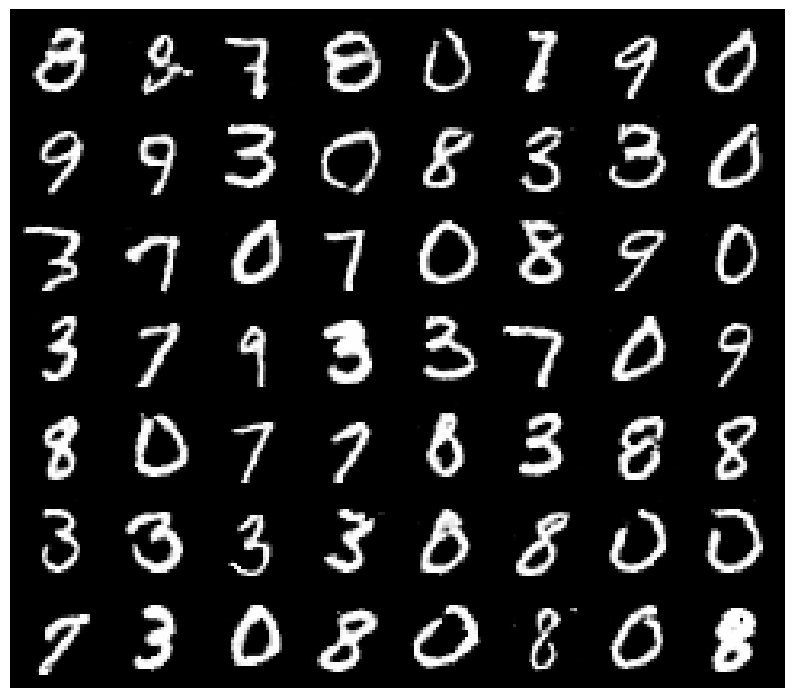

100%|███████████████████████████████████████████████████████| 732/732 [00:56<00:00, 12.91it/s, loss_D=0.53, loss_G=2.3]


Epoch [182/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [182/400] - Average D loss: 0.5878, Average G loss: 2.0910


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.13it/s, loss_D=0.503, loss_G=2.13]


Epoch [183/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [183/400] - Average D loss: 0.5875, Average G loss: 2.0760


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.16it/s, loss_D=0.621, loss_G=2.12]


Epoch [184/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [184/400] - Average D loss: 0.6180, Average G loss: 2.0385


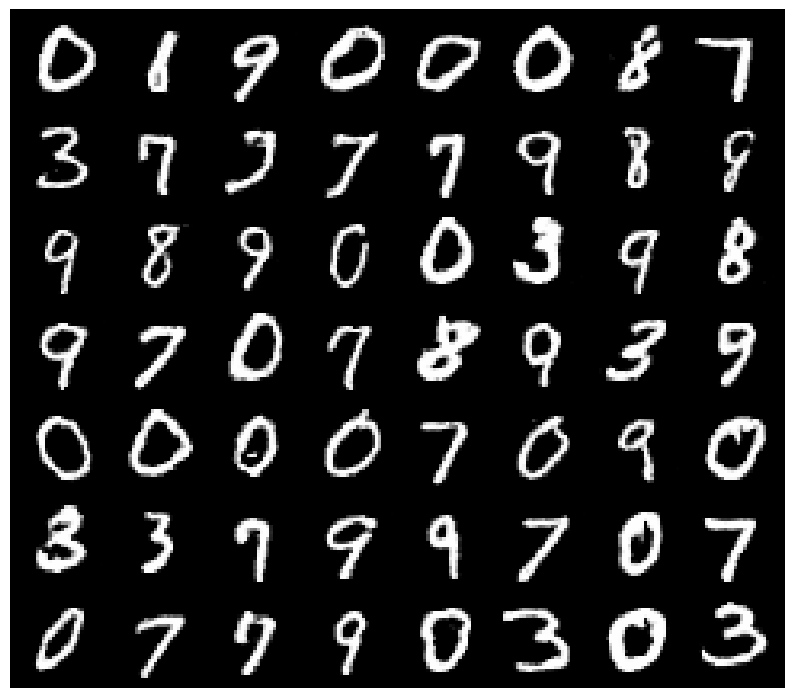

100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 12.91it/s, loss_D=0.606, loss_G=1.78]


Epoch [185/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [185/400] - Average D loss: 0.6079, Average G loss: 2.0001


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.24it/s, loss_D=0.426, loss_G=2.07]


Epoch [186/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [186/400] - Average D loss: 0.6036, Average G loss: 2.0250


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.22it/s, loss_D=0.744, loss_G=1.75]


Epoch [187/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [187/400] - Average D loss: 0.6009, Average G loss: 2.0411


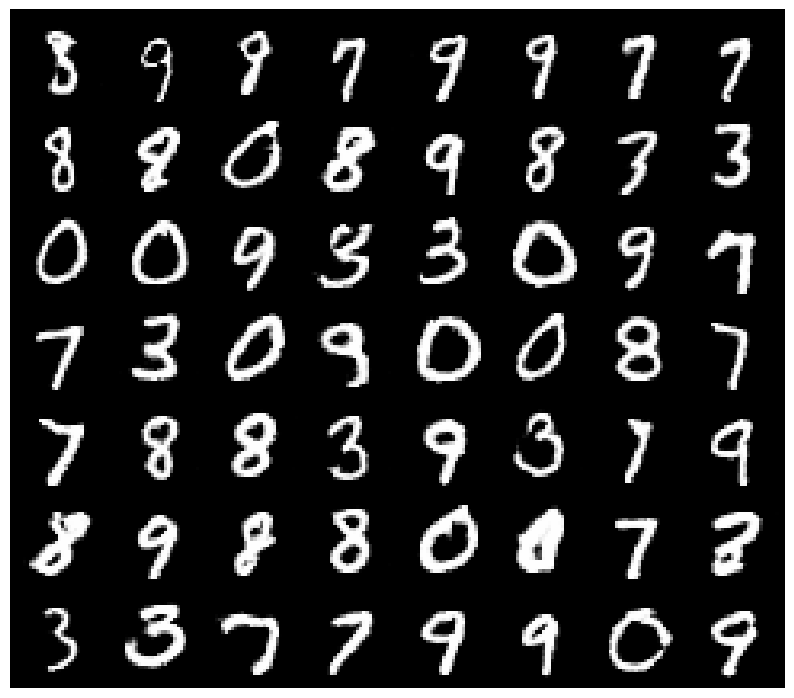

100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 13.02it/s, loss_D=0.671, loss_G=1.96]


Epoch [188/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [188/400] - Average D loss: 0.5979, Average G loss: 2.0585


100%|██████████████████████████████████████████████████████| 732/732 [00:56<00:00, 12.98it/s, loss_D=0.71, loss_G=2.02]


Epoch [189/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [189/400] - Average D loss: 0.5879, Average G loss: 2.0724


100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 12.88it/s, loss_D=0.594, loss_G=1.81]


Epoch [190/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [190/400] - Average D loss: 0.5931, Average G loss: 2.0755


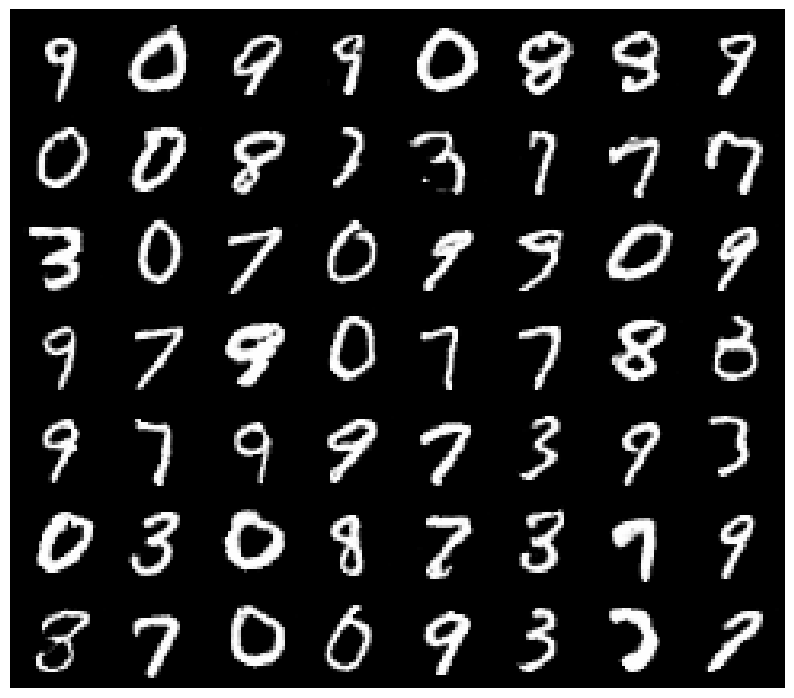

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.10it/s, loss_D=0.503, loss_G=2.24]


Epoch [191/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [191/400] - Average D loss: 0.5944, Average G loss: 2.0584


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.27it/s, loss_D=0.569, loss_G=2.05]


Epoch [192/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [192/400] - Average D loss: 0.6074, Average G loss: 2.0625


100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 12.97it/s, loss_D=0.608, loss_G=2.03]


Epoch [193/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [193/400] - Average D loss: 0.5930, Average G loss: 2.0592


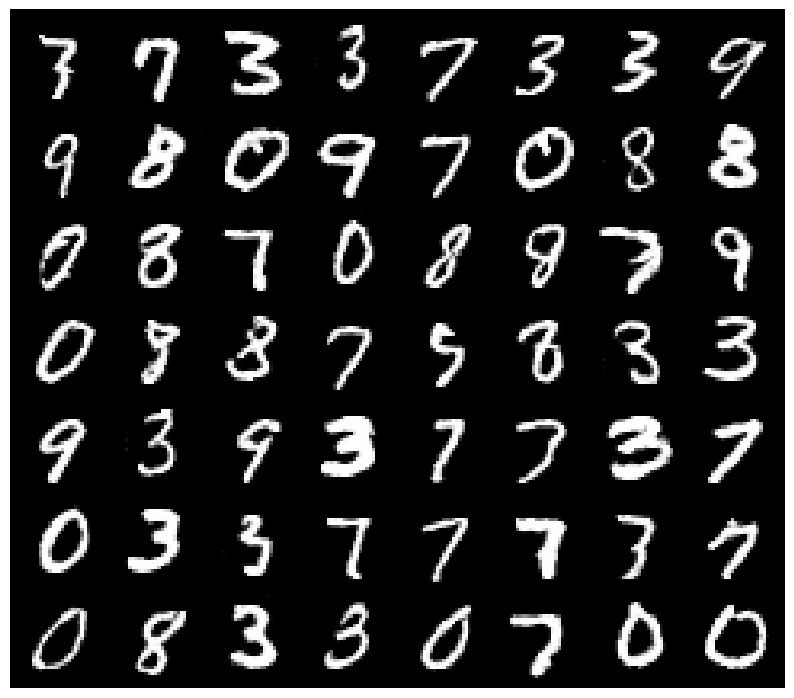

100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 12.95it/s, loss_D=0.627, loss_G=2.05]


Epoch [194/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [194/400] - Average D loss: 0.5922, Average G loss: 2.0670


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.16it/s, loss_D=0.626, loss_G=1.92]


Epoch [195/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [195/400] - Average D loss: 0.5962, Average G loss: 2.0662


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.22it/s, loss_D=0.631, loss_G=1.89]


Epoch [196/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [196/400] - Average D loss: 0.5912, Average G loss: 2.0646


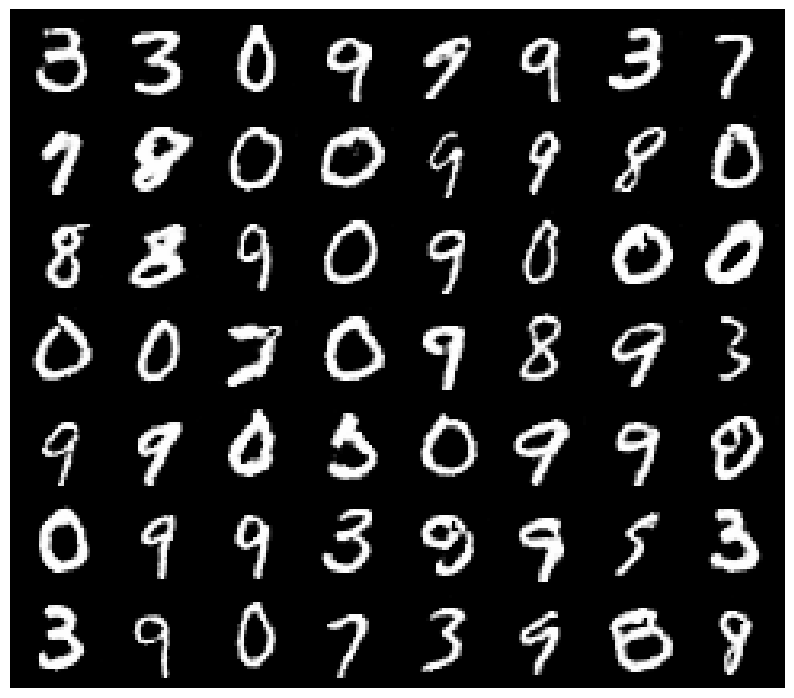

100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.42it/s, loss_D=0.432, loss_G=2.09]


Epoch [197/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [197/400] - Average D loss: 0.5879, Average G loss: 2.0779


100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 12.87it/s, loss_D=0.505, loss_G=2.02]


Epoch [198/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [198/400] - Average D loss: 0.5894, Average G loss: 2.0761


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.26it/s, loss_D=0.564, loss_G=2.06]


Epoch [199/400] - LR G: 0.0000137, LR D: 0.0000137
Epoch [199/400] - Average D loss: 0.5887, Average G loss: 2.0855


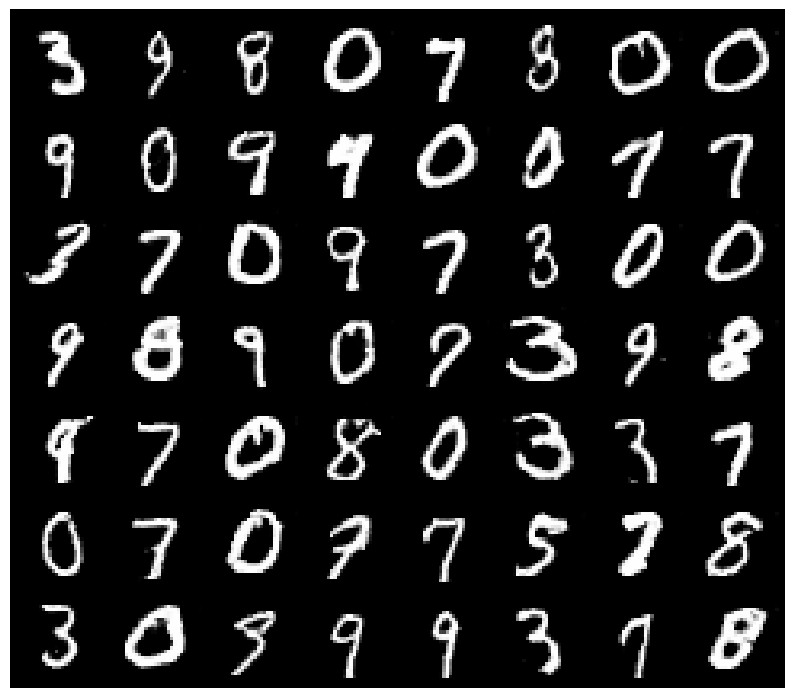

100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.36it/s, loss_D=0.648, loss_G=2.09]


Epoch [200/400] - LR G: 0.0000110, LR D: 0.0000110
Epoch [200/400] - Average D loss: 0.5886, Average G loss: 2.0745


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.28it/s, loss_D=0.501, loss_G=2.11]


Epoch [201/400] - LR G: 0.0000110, LR D: 0.0000110
Epoch [201/400] - Average D loss: 0.5870, Average G loss: 2.0825


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.10it/s, loss_D=0.495, loss_G=1.97]


Epoch [202/400] - LR G: 0.0000110, LR D: 0.0000110
Epoch [202/400] - Average D loss: 0.5891, Average G loss: 2.0741


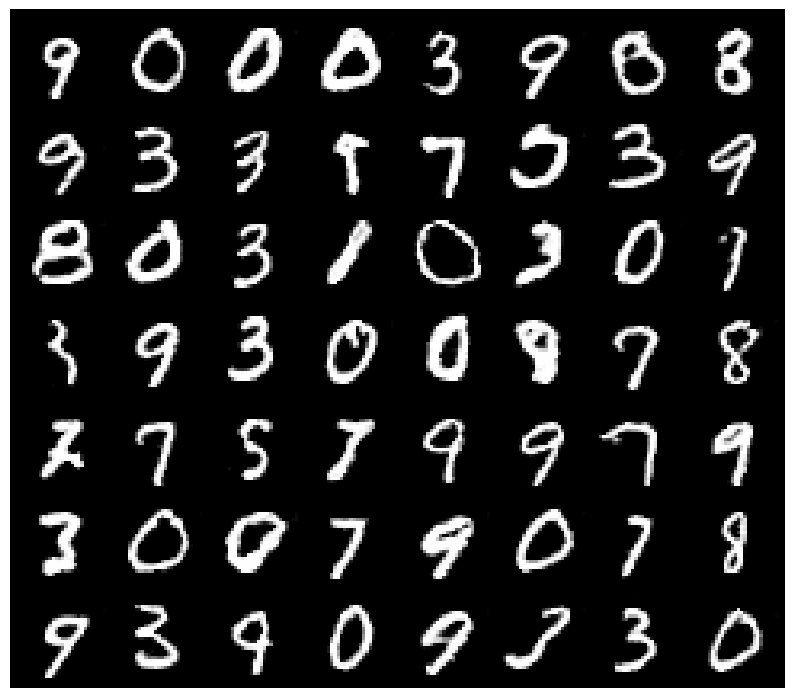

100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.65it/s, loss_D=0.721, loss_G=2.1]


Epoch [203/400] - LR G: 0.0000110, LR D: 0.0000110
Epoch [203/400] - Average D loss: 0.5875, Average G loss: 2.0749


100%|██████████████████████████████████████████████████████| 732/732 [39:41<00:00,  3.25s/it, loss_D=0.633, loss_G=2.1]


Epoch [271/400] - LR G: 0.0000056, LR D: 0.0000056
Epoch [271/400] - Average D loss: 0.5841, Average G loss: 2.0915


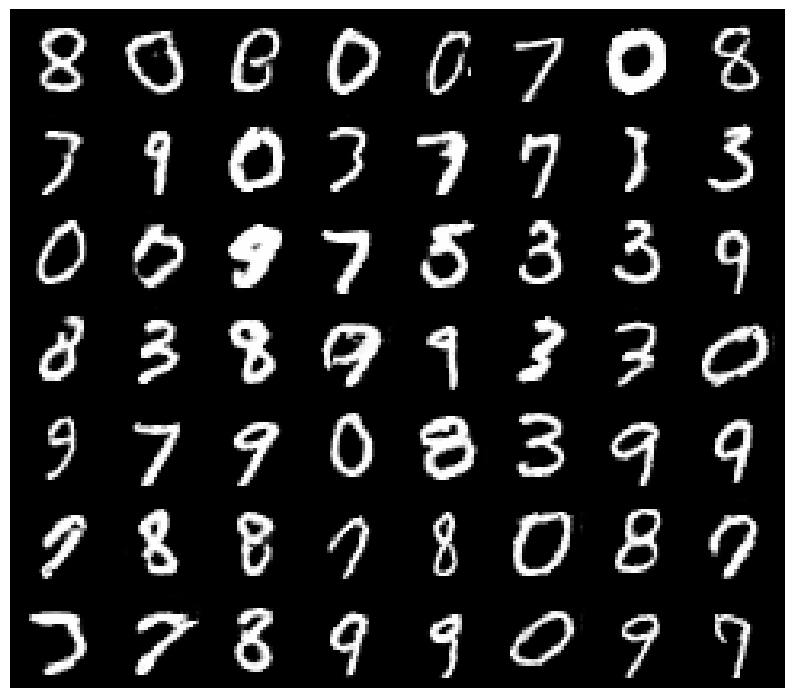

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.576, loss_G=2.22]


Epoch [272/400] - LR G: 0.0000056, LR D: 0.0000056
Epoch [272/400] - Average D loss: 0.5858, Average G loss: 2.0835


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.04it/s, loss_D=0.566, loss_G=2.09]


Epoch [274/400] - LR G: 0.0000056, LR D: 0.0000056
Epoch [274/400] - Average D loss: 0.5828, Average G loss: 2.0937


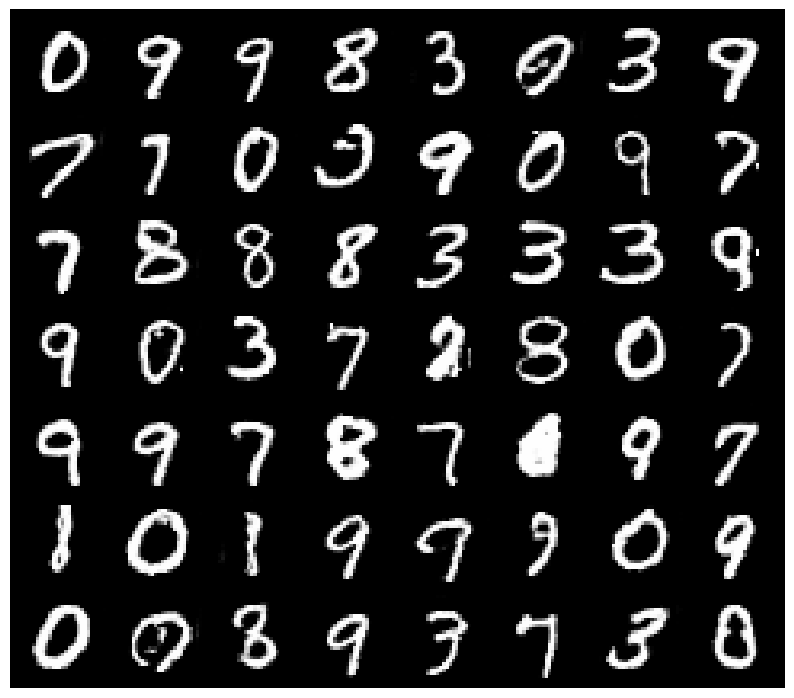

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.525, loss_G=2.11]


Epoch [275/400] - LR G: 0.0000056, LR D: 0.0000056
Epoch [275/400] - Average D loss: 0.5844, Average G loss: 2.0755


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=0.493, loss_G=2.14]


Epoch [276/400] - LR G: 0.0000056, LR D: 0.0000056
Epoch [276/400] - Average D loss: 0.5848, Average G loss: 2.0811


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.95it/s, loss_D=0.443, loss_G=2.07]


Epoch [280/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [280/400] - Average D loss: 0.5827, Average G loss: 2.0805


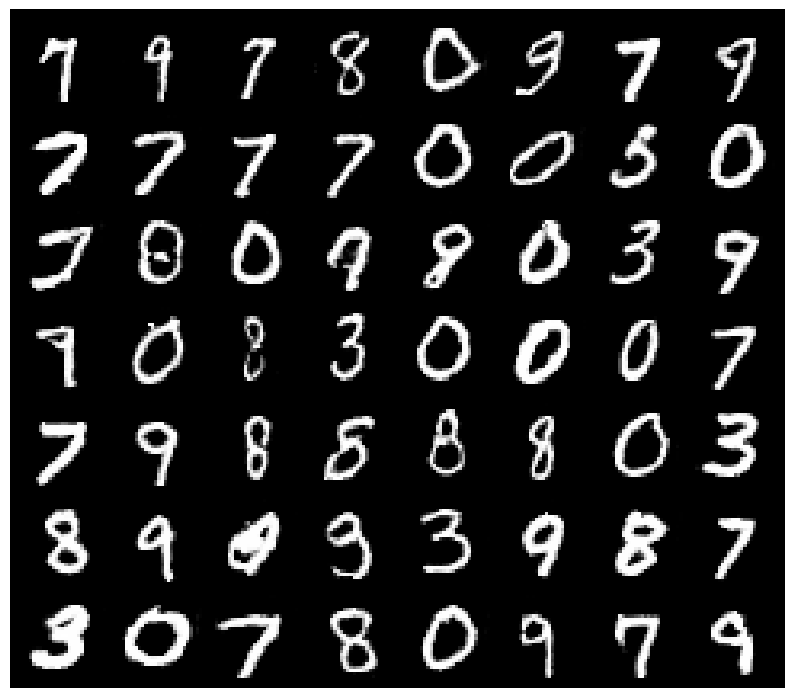

100%|█████████████████████████████████████████████████████| 732/732 [00:50<00:00, 14.40it/s, loss_D=0.729, loss_G=2.19]


Epoch [285/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [285/400] - Average D loss: 0.5870, Average G loss: 2.0891


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.34it/s, loss_D=0.665, loss_G=2.03]


Epoch [289/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [289/400] - Average D loss: 0.5832, Average G loss: 2.0833


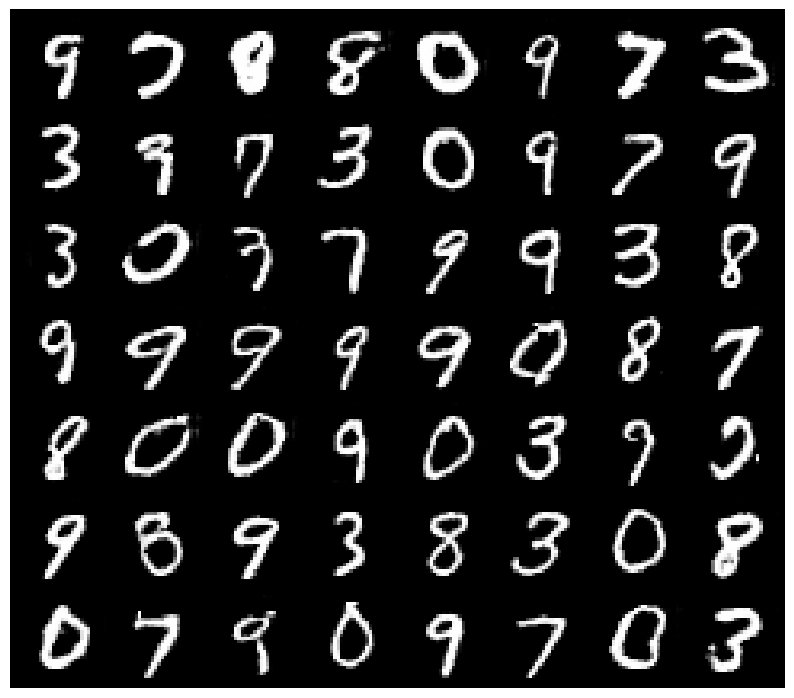

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.585, loss_G=2.18]


Epoch [290/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [290/400] - Average D loss: 0.5826, Average G loss: 2.0825


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.91it/s, loss_D=0.584, loss_G=2.01]


Epoch [294/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [294/400] - Average D loss: 0.5824, Average G loss: 2.0818


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.628, loss_G=1.99]


Epoch [295/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [295/400] - Average D loss: 0.5858, Average G loss: 2.0816


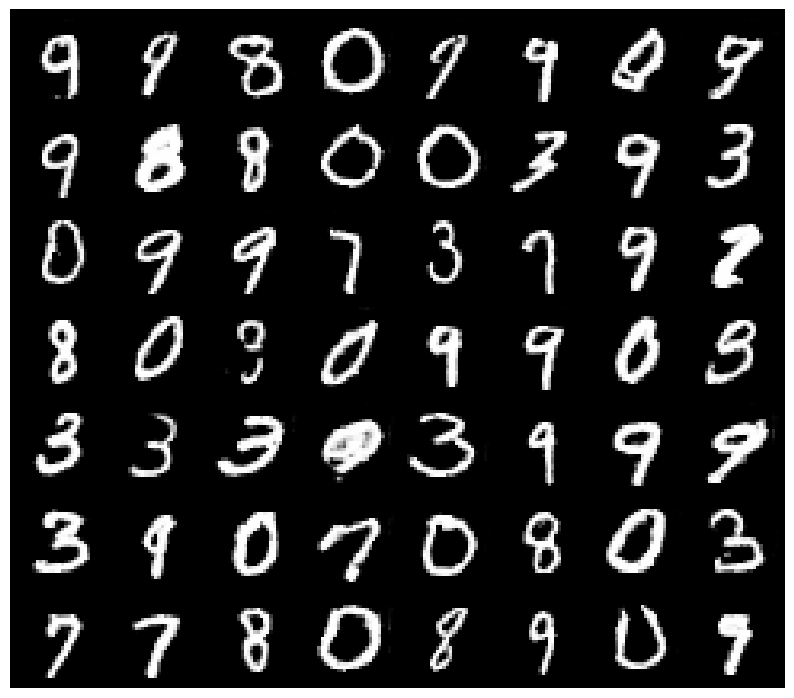

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.02it/s, loss_D=0.473, loss_G=2.34]


Epoch [299/400] - LR G: 0.0000045, LR D: 0.0000045
Epoch [299/400] - Average D loss: 0.5834, Average G loss: 2.0933


100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.75it/s, loss_D=0.54, loss_G=1.96]


Epoch [300/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [300/400] - Average D loss: 0.5857, Average G loss: 2.0830


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.867, loss_G=1.85]


Epoch [304/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [304/400] - Average D loss: 0.5834, Average G loss: 2.0860


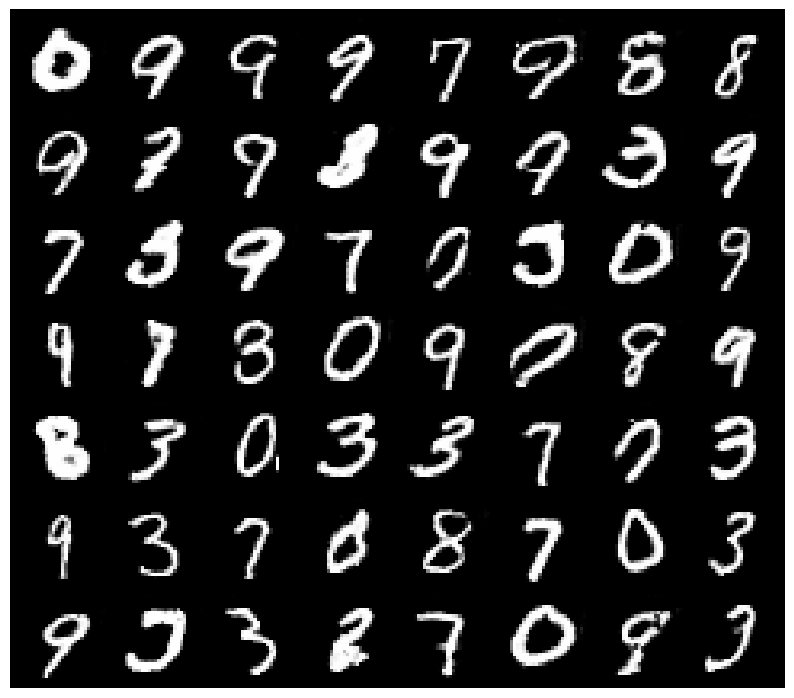

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.81it/s, loss_D=0.568, loss_G=1.97]


Epoch [305/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [305/400] - Average D loss: 0.5829, Average G loss: 2.0833


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.89it/s, loss_D=0.594, loss_G=2.13]


Epoch [308/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [308/400] - Average D loss: 0.5831, Average G loss: 2.0890


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=0.732, loss_G=1.98]


Epoch [309/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [309/400] - Average D loss: 0.5817, Average G loss: 2.0926


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.08it/s, loss_D=0.586, loss_G=2.12]


Epoch [313/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [313/400] - Average D loss: 0.5803, Average G loss: 2.0935


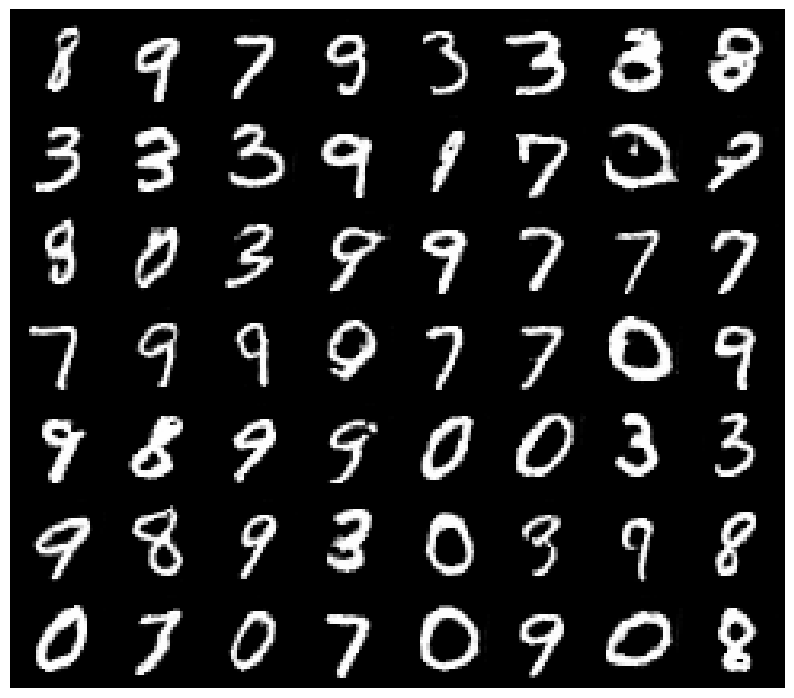

100%|███████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.92it/s, loss_D=0.64, loss_G=2.2]


Epoch [314/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [314/400] - Average D loss: 0.5836, Average G loss: 2.0896


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.86it/s, loss_D=0.675, loss_G=2.2]


Epoch [317/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [317/400] - Average D loss: 0.5807, Average G loss: 2.0997


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.95it/s, loss_D=0.518, loss_G=2.06]


Epoch [318/400] - LR G: 0.0000036, LR D: 0.0000036
Epoch [318/400] - Average D loss: 0.5770, Average G loss: 2.0880


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.33it/s, loss_D=0.644, loss_G=2.22]


Epoch [322/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [322/400] - Average D loss: 0.5797, Average G loss: 2.0985


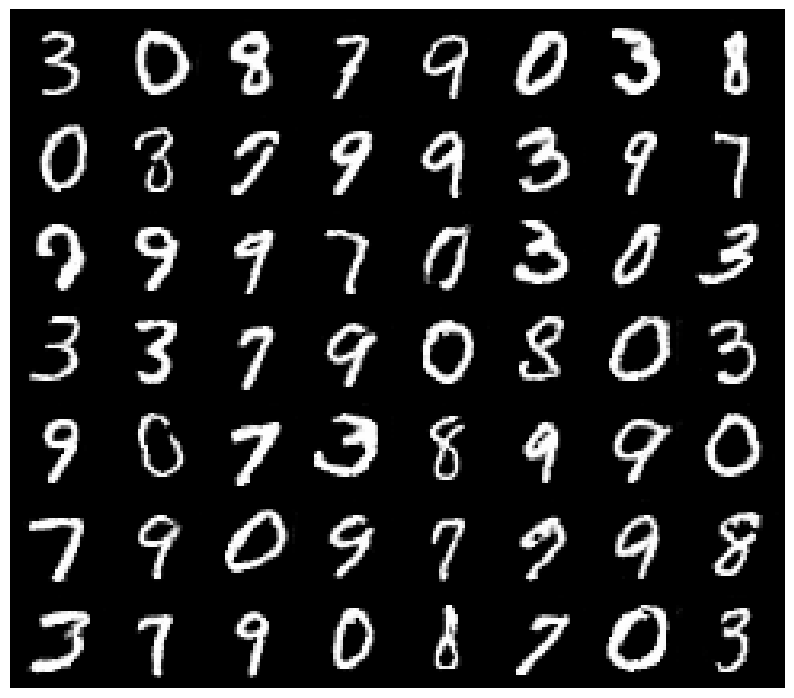

100%|███████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.64it/s, loss_D=0.45, loss_G=1.9]


Epoch [323/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [323/400] - Average D loss: 0.5780, Average G loss: 2.0916


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.81it/s, loss_D=0.563, loss_G=2.12]


Epoch [327/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [327/400] - Average D loss: 0.5809, Average G loss: 2.0879


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.84it/s, loss_D=0.549, loss_G=1.93]


Epoch [328/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [328/400] - Average D loss: 0.5802, Average G loss: 2.1067


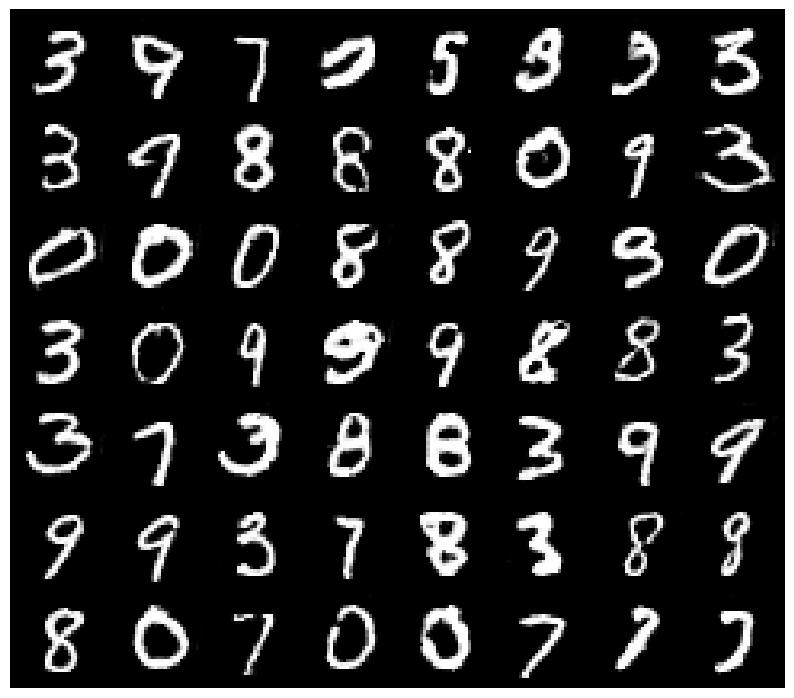

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.96it/s, loss_D=0.525, loss_G=2.18]


Epoch [331/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [331/400] - Average D loss: 0.5819, Average G loss: 2.0958


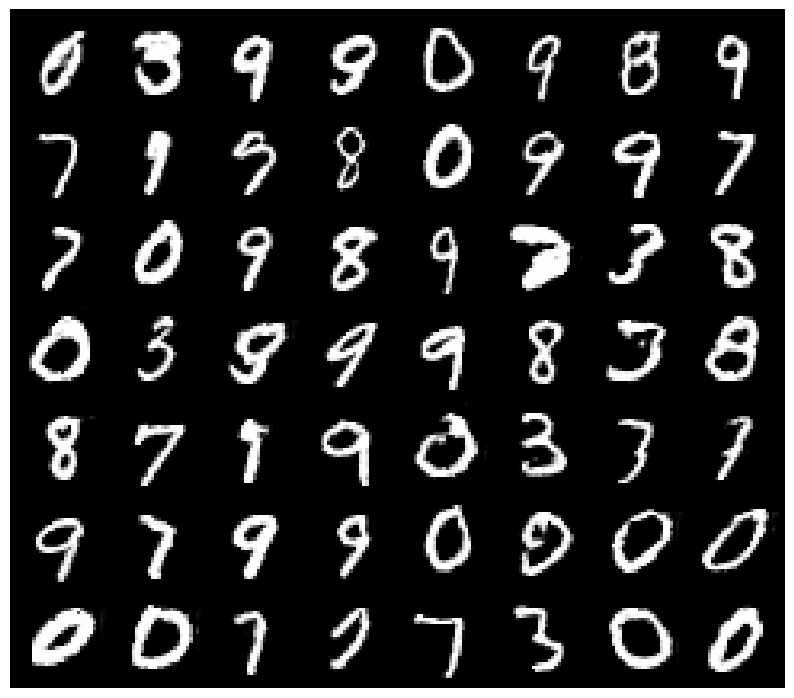

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.10it/s, loss_D=0.513, loss_G=2.06]


Epoch [332/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [332/400] - Average D loss: 0.5762, Average G loss: 2.0935


100%|█████████████████████████████████████████████████████| 732/732 [01:10<00:00, 10.44it/s, loss_D=0.681, loss_G=1.93]


Epoch [336/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [336/400] - Average D loss: 0.5810, Average G loss: 2.0957


100%|██████████████████████████████████████████████████████| 732/732 [01:11<00:00, 10.27it/s, loss_D=0.535, loss_G=2.4]


Epoch [337/400] - LR G: 0.0000029, LR D: 0.0000029
Epoch [337/400] - Average D loss: 0.5810, Average G loss: 2.0883


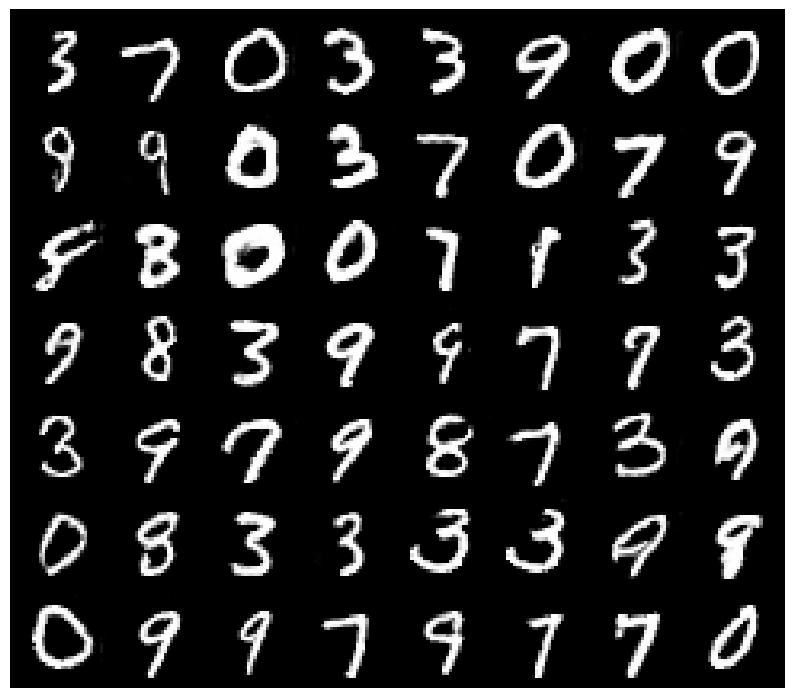

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.16it/s, loss_D=0.697, loss_G=2.21]


Epoch [340/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [340/400] - Average D loss: 0.5792, Average G loss: 2.1013


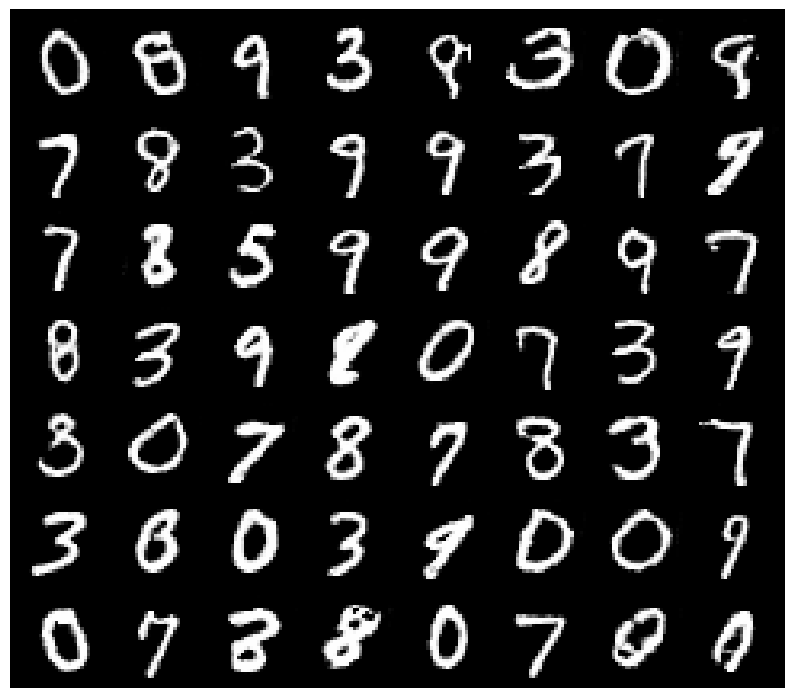

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.13it/s, loss_D=0.548, loss_G=2.09]


Epoch [341/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [341/400] - Average D loss: 0.5795, Average G loss: 2.0991


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.42it/s, loss_D=0.476, loss_G=2.09]


Epoch [344/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [344/400] - Average D loss: 0.5811, Average G loss: 2.0871


100%|█████████████████████████████████████████████████████| 732/732 [00:56<00:00, 13.00it/s, loss_D=0.612, loss_G=2.07]


Epoch [345/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [345/400] - Average D loss: 0.5769, Average G loss: 2.0924


100%|██████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.21it/s, loss_D=0.59, loss_G=2.07]


Epoch [349/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [349/400] - Average D loss: 0.5805, Average G loss: 2.0934


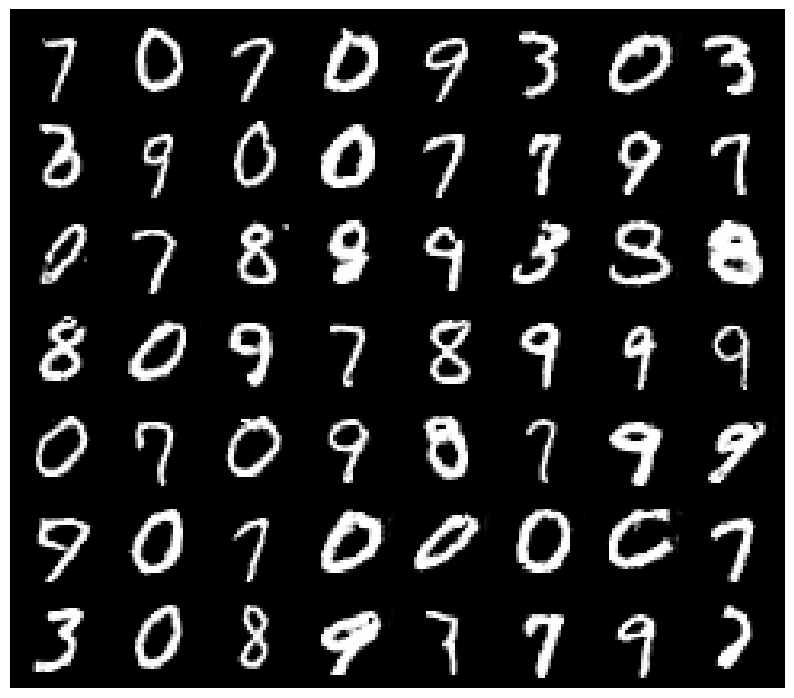

100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.24it/s, loss_D=0.558, loss_G=2.14]


Epoch [353/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [353/400] - Average D loss: 0.5780, Average G loss: 2.1055


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.54it/s, loss_D=0.689, loss_G=1.98]


Epoch [354/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [354/400] - Average D loss: 0.5780, Average G loss: 2.0951


100%|█████████████████████████████████████████████████████| 732/732 [00:54<00:00, 13.51it/s, loss_D=0.534, loss_G=2.12]


Epoch [358/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [358/400] - Average D loss: 0.5797, Average G loss: 2.0968


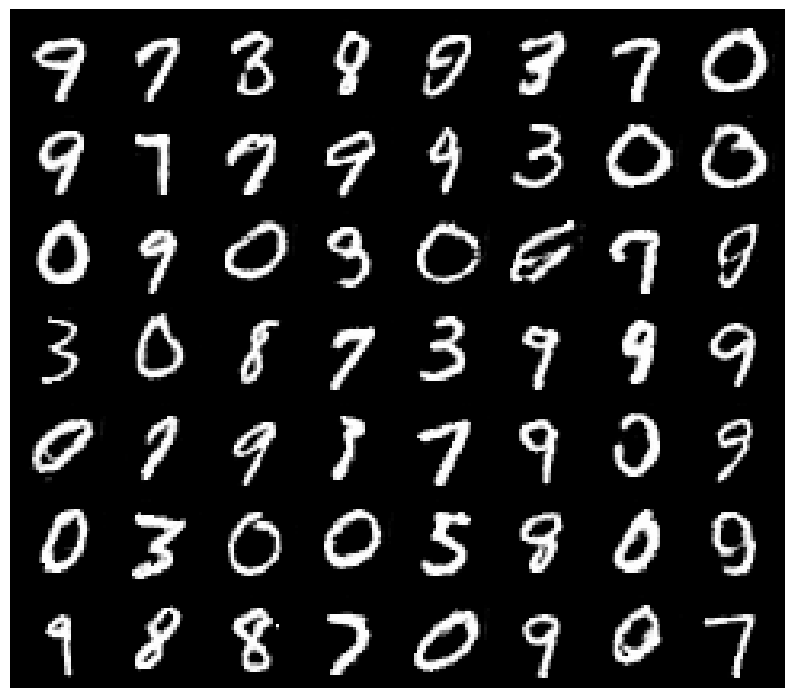

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.58it/s, loss_D=0.607, loss_G=2.12]


Epoch [359/400] - LR G: 0.0000023, LR D: 0.0000023
Epoch [359/400] - Average D loss: 0.5751, Average G loss: 2.1044


100%|█████████████████████████████████████████████████████| 732/732 [00:55<00:00, 13.26it/s, loss_D=0.653, loss_G=2.02]


Epoch [363/400] - LR G: 0.0000018, LR D: 0.0000018
Epoch [363/400] - Average D loss: 0.5777, Average G loss: 2.0977


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.74it/s, loss_D=0.472, loss_G=2.15]


Epoch [364/400] - LR G: 0.0000018, LR D: 0.0000018
Epoch [364/400] - Average D loss: 0.5771, Average G loss: 2.1021


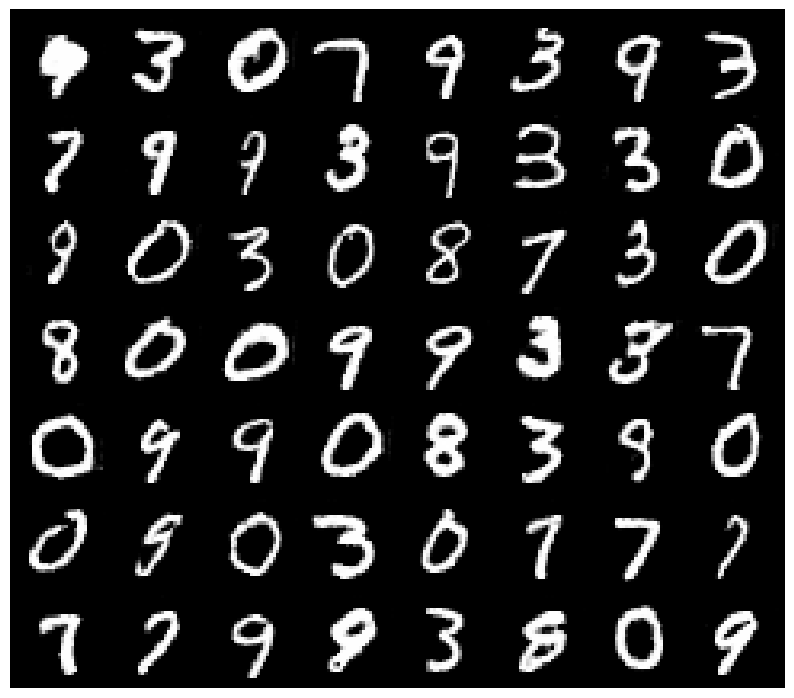

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.02it/s, loss_D=0.715, loss_G=2.15]


Epoch [368/400] - LR G: 0.0000018, LR D: 0.0000018
Epoch [368/400] - Average D loss: 0.5774, Average G loss: 2.0961


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.14it/s, loss_D=0.538, loss_G=2.13]


Epoch [372/400] - LR G: 0.0000018, LR D: 0.0000018
Epoch [372/400] - Average D loss: 0.5808, Average G loss: 2.1011


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.01it/s, loss_D=0.545, loss_G=2.12]


Epoch [373/400] - LR G: 0.0000018, LR D: 0.0000018
Epoch [373/400] - Average D loss: 0.5796, Average G loss: 2.0963


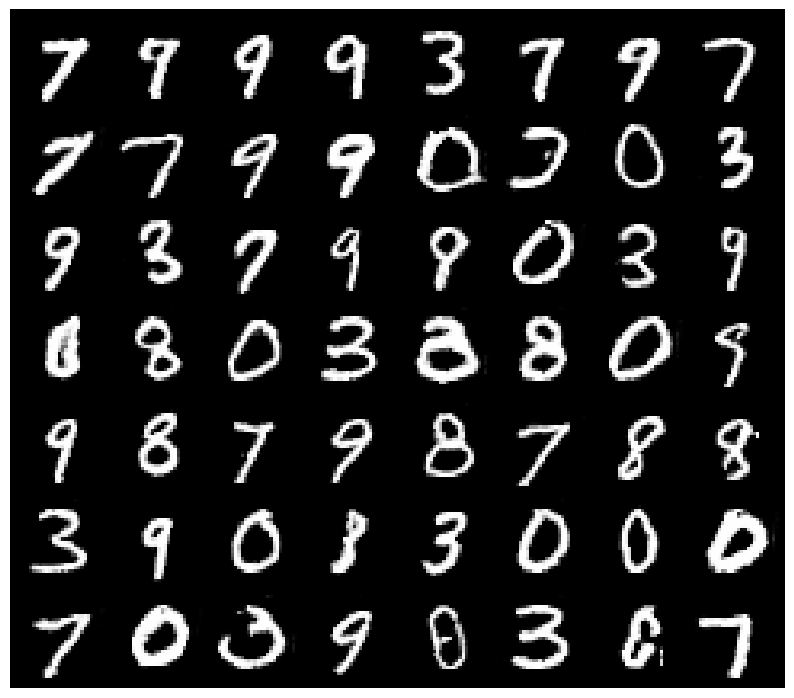

100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.24it/s, loss_D=0.59, loss_G=2.14]


Epoch [377/400] - LR G: 0.0000018, LR D: 0.0000018
Epoch [377/400] - Average D loss: 0.5895, Average G loss: 2.1089


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.06it/s, loss_D=0.525, loss_G=2.07]


Epoch [378/400] - LR G: 0.0000018, LR D: 0.0000018
Epoch [378/400] - Average D loss: 0.5898, Average G loss: 2.0870


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.88it/s, loss_D=0.601, loss_G=1.98]


Epoch [382/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [382/400] - Average D loss: 0.5805, Average G loss: 2.0987


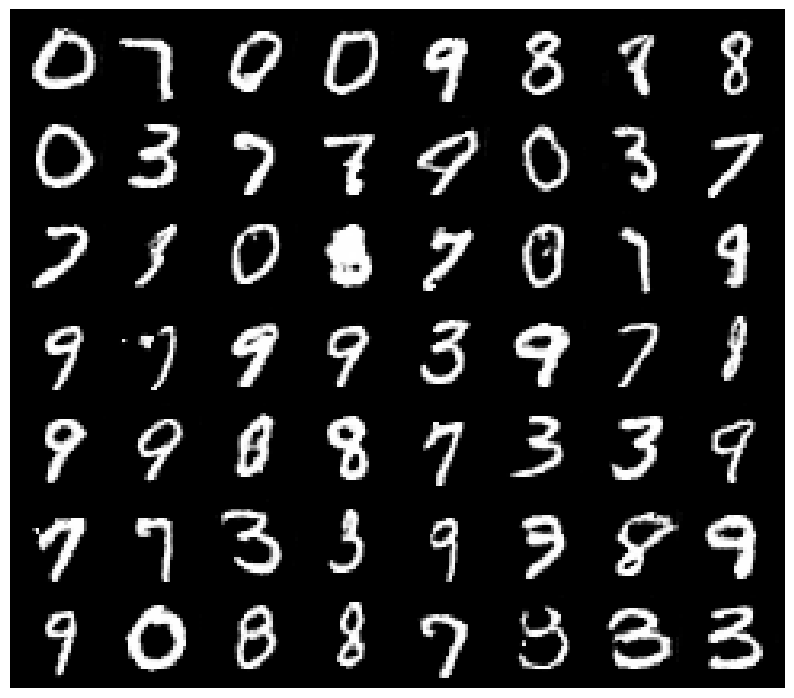

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.92it/s, loss_D=0.603, loss_G=1.9]


Epoch [383/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [383/400] - Average D loss: 0.5836, Average G loss: 2.0955


100%|██████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.15it/s, loss_D=0.556, loss_G=1.9]


Epoch [387/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [387/400] - Average D loss: 0.5776, Average G loss: 2.0973


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.24it/s, loss_D=0.437, loss_G=2.34]


Epoch [388/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [388/400] - Average D loss: 0.5733, Average G loss: 2.1001


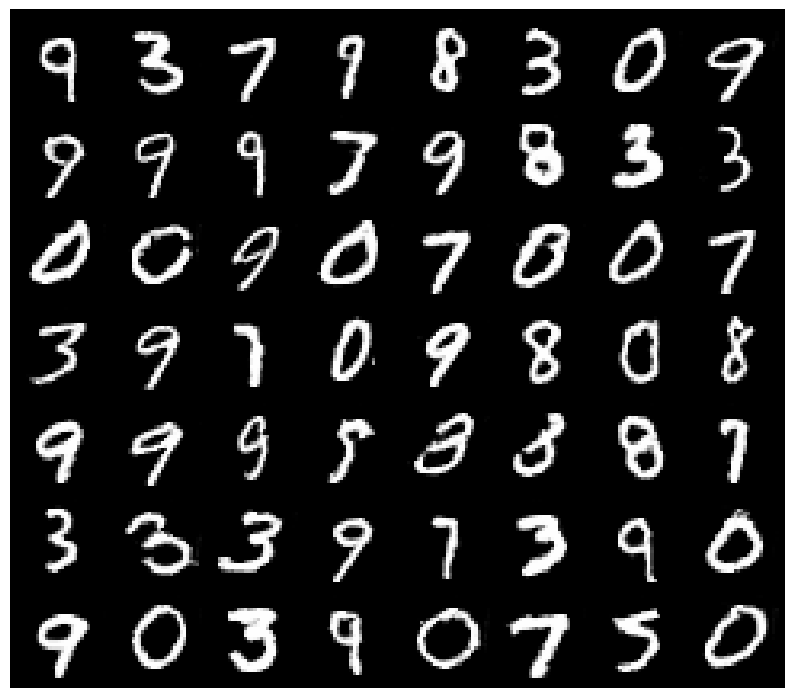

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.627, loss_G=2.02]


Epoch [392/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [392/400] - Average D loss: 0.5785, Average G loss: 2.1008


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.87it/s, loss_D=0.611, loss_G=1.96]


Epoch [393/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [393/400] - Average D loss: 0.5817, Average G loss: 2.1036


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.83it/s, loss_D=0.549, loss_G=2.21]


Epoch [397/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [397/400] - Average D loss: 0.5788, Average G loss: 2.1013


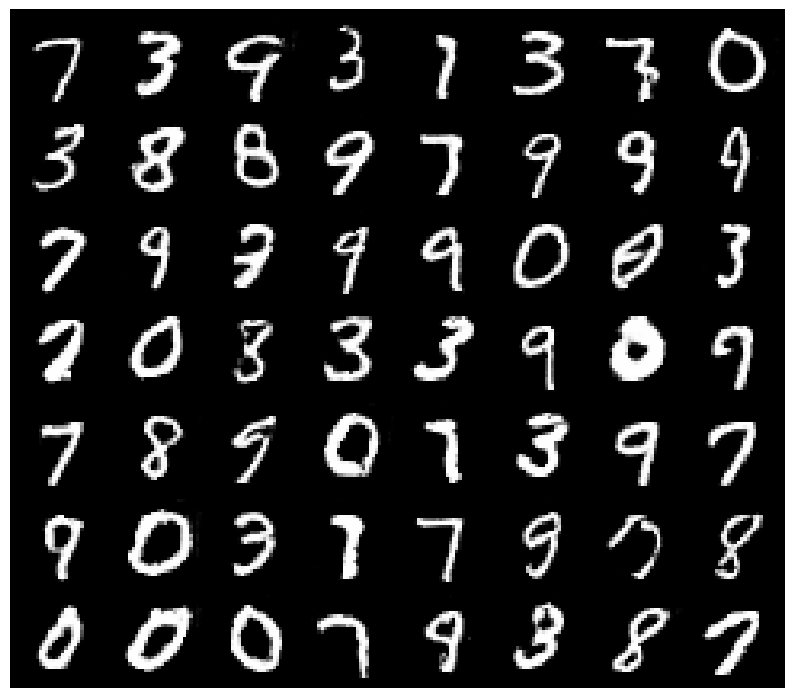

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=0.586, loss_G=1.92]


Epoch [398/400] - LR G: 0.0000015, LR D: 0.0000015
Epoch [398/400] - Average D loss: 0.5751, Average G loss: 2.1035


 42%|██████████████████████▎                              | 308/732 [00:22<00:29, 14.46it/s, loss_D=0.499, loss_G=1.88]

In [ ]:
def preprocess_images(images):
    normalized_images = (generated_images + 1) / 2
    display_images = (normalized_images * 255).type(torch.uint8)
    return display_images

# Initialize variables
min_g_loss = float('inf')
epochs = 400
average_d_losses = []  # List to store average discriminator losses per epoch
average_g_losses = []  # List to store average generator losses per epoch

# Assume definitions of loader_discriminator, discriminator, generator, optim_D, and optim_G

for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0
    count_batches = 0

    loop = tqdm(loader_discriminator, leave=True, total=len(loader_discriminator))
    for real_imgs, _ in loop:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        optim_D.zero_grad()
        real_preds = discriminator(real_imgs)
        real_loss = F.binary_cross_entropy(real_preds, real_labels)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = generator(noise)
        fake_preds = discriminator(fake_imgs.detach())
        fake_loss = F.binary_cross_entropy(fake_preds, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_D.step()

        optim_G.zero_grad()
        tricked_preds = discriminator(fake_imgs)
        g_loss = F.binary_cross_entropy(tricked_preds, real_labels)
        g_loss.backward()
        optim_G.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        count_batches += 1

        loop.set_postfix(loss_D=d_loss.item(), loss_G=g_loss.item())

    avg_d_loss = total_d_loss / count_batches
    avg_g_loss = total_g_loss / count_batches

    average_d_losses.append(avg_d_loss)
    average_g_losses.append(avg_g_loss)

    scheduler_G.step()
    scheduler_D.step()

    lr_G = optim_G.param_groups[0]['lr']
    lr_D = optim_D.param_groups[0]['lr']

    # Print current learning rates
    print(f"Epoch [{epoch + 1}/{epochs}] - LR G: {lr_G:.7f}, LR D: {lr_D:.7f}")
    print(f"Epoch [{epoch + 1}/{epochs}] - Average D loss: {avg_d_loss:.4f}, Average G loss: {avg_g_loss:.4f}")

    if epoch % 3 == 0:
        with torch.no_grad():
            test_noise = torch.randn(batch_size, noise_dim).to(device)
            generated_images = generator(test_noise)
            generated_images = preprocess_images(generated_images)

            plt.figure(figsize=(10, 10))
            grid = make_grid(generated_images, nrow=8)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

torch.save(generator.state_dict(), 'best_generator.pth')

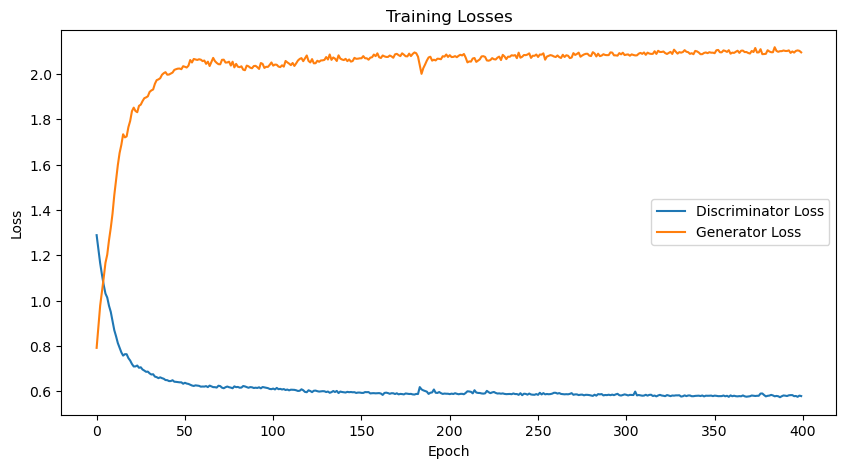

In [21]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(average_d_losses, label='Discriminator Loss')
plt.plot(average_g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
def calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O):
    """
    Calculate the output dimensions (height and width) of a transposed convolution layer.

    Parameters:
    H_in (int): Height of the input feature map.
    W_in (int): Width of the input feature map.
    K (int): Kernel size.
    S (int): Stride.
    P (int): Padding applied to the input.
    O (int): Output padding.

    Returns:
    tuple: (H_out, W_out) output height and width.
    """
    H_out = (H_in - 1) * S - 2 * P + K + O
    W_out = (W_in - 1) * S - 2 * P + K + O
    return H_out, W_out

# Example usage with specific parameters
H_in, W_in = 26, 26  # Example input dimensions
K = 3             # Kernel size
S = 1              # Stride
P = 0              # Padding
O = 0              # Output padding

# Calculate output dimensions
output_dims = calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O)
output_dims

(28, 28)

In [23]:
def calculate_conv_output_size(input_size, kernel_size, stride, padding):
    """
    Calculate the output size of a convolutional layer.

    Args:
    input_size (tuple): The height and width of the input image (height, width).
    kernel_size (int): The size of the kernel/filter.
    stride (int): The stride of the convolution operation.
    padding (int): The padding added to the input image.

    Returns:
    tuple: The height and width of the output image (height, width).
    """
    input_height, input_width = input_size

    output_height = (input_height + 2 * padding - kernel_size) // stride + 1
    output_width = (input_width + 2 * padding - kernel_size) // stride + 1

    return (output_height, output_width)

# Example usage:
input_height = 28  # Example input height
input_width = 28   # Example input width
kernel_size = 3
stride = 2
padding = 2

output_size = calculate_conv_output_size((input_height, input_width), kernel_size, stride, padding)
print("Output size:", output_size)

Output size: (15, 15)


In [24]:
# Load the trained generator weights
generator.load_state_dict(torch.load('best_generator.pth'))
generator.eval()  # Set to evaluation mode

Generator(
  (fc): Linear(in_features=49, out_features=49, bias=True)
  (convT1): ConvTranspose2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)

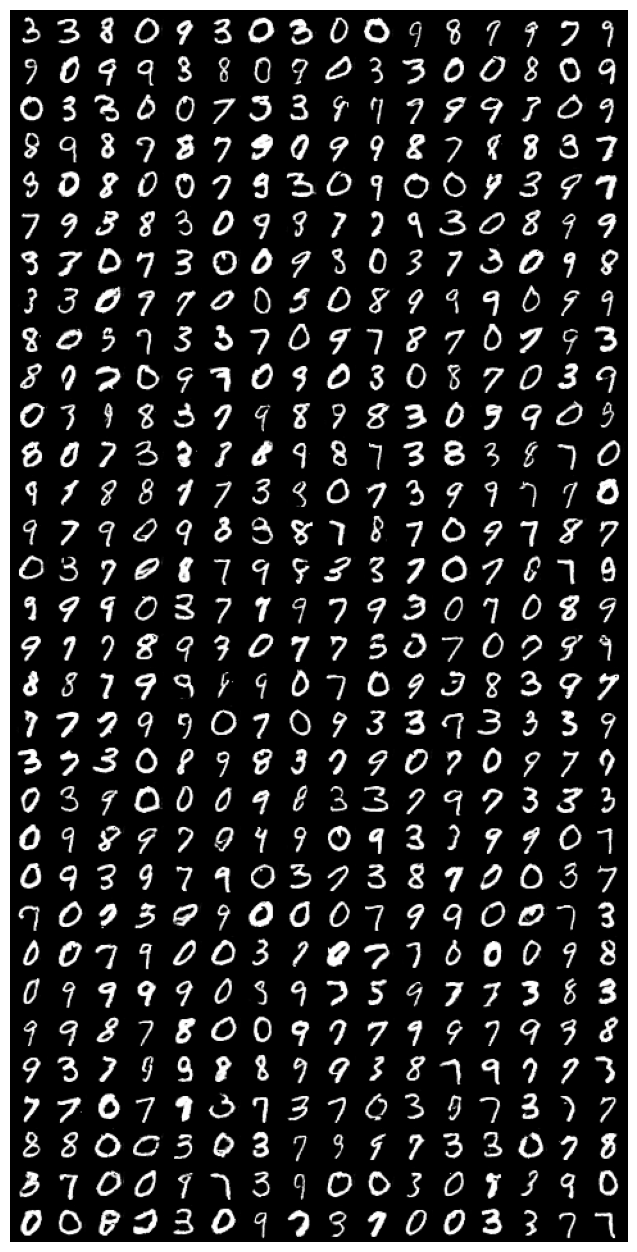

In [25]:
# Generate noise vectors
batch_size = 512  # Number of images to generate
noise = torch.randn(batch_size, noise_dim).to(device)

# Generate images from noise vectors
with torch.no_grad():
    fake_images = generator(noise)

# Assuming images are 28x28 and need to be reshaped
fake_images = fake_images.view(batch_size, 1, 28, 28)  # Reshape images to BxCxHxW format if needed
grid = make_grid(fake_images, nrow=16, normalize=True)  # Create a grid of images

# Visualize images
plt.figure(figsize=(16, 16))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Adjust the channel ordering
plt.axis('off')
plt.show()
